#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

2021-07-07 07:19:30,995- WARNING•	QuickBB solver is unavailable
2021-07-07 07:19:30,996- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


# Aim
See unweighted and weighted scores for graphs that don't tranfer well; if high, then subgraphs can't predict similarity

# Data Collection Details

y = 5

x = 11*y

Use data stored in drive to generate subgraph_similarity_metric vs actual similarity for random graphs

All random graphs have 20 nodes but they differ in how many even degree nodes they have. There are a total of x graphs-- y of them with 0 even nodes, y with 2 even degree nodes , ..., y with all 20 even degree nodes. (Generating 20-node graphs with say odd number of even degree nodes like 3 even degree nodes was not possible ---it raised networkx.exception.NXUnfeasible )

Also when I say y graphs with same even degree nodes, they also have same degree sequence. But they are different i.e. non-isomorphic/

** Now debugging why some graphs, having different parity have high tranferability **

# Tranferability Matrices for Subgraphs
one of them uses the averaging technique, the other uses the best of 20 trick

# Why Mutual Tranferability
In the tranferability paper, we saw patterns in how even and odd subgraphs tranfer. But there was an important claim underlying that blue colormap: all the subgraphs was mutually tranferable. Well, that fact is trvial, but not so in our case, where we are not comparing subgraphs but larger random graphs. 

I'm calling a graph odd based on the number of even degree nodes it has. But that does not mean, like an odd subgraph, it is mutually tranferable. Let me repeat: Odd subgraphs are mutually tranferable. But "odd" graphs are not necessarily so!

Now in the paper, there were 3 conditions for tranferability:
1. Donor graph is mutually transferable
2. Acceptor graph is mutually transferable
3. All subgraphs in donor graph are tranferable to all subgraphs in acceptor graph.

My **hypothesis** is that conditions #1 and #2 affect number #3. Specifically, I claim that mutual tranferability of donor and acceptor graphs affects how well we can predict similarity between the pair. (i.e. **how close subgraph similarity metric is to actualy similarity**)

# Transferability Matrix


In [2]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

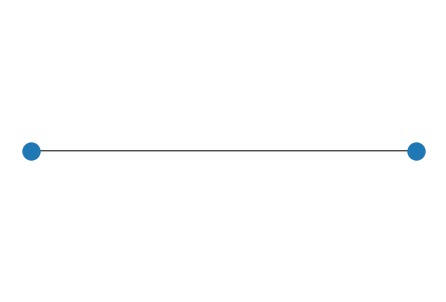

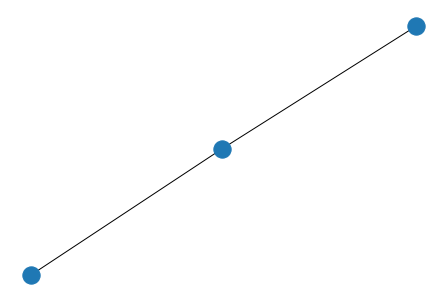

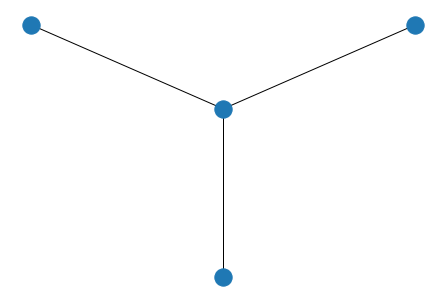

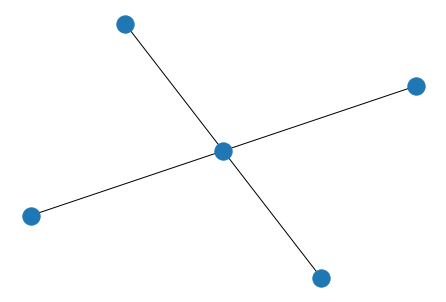

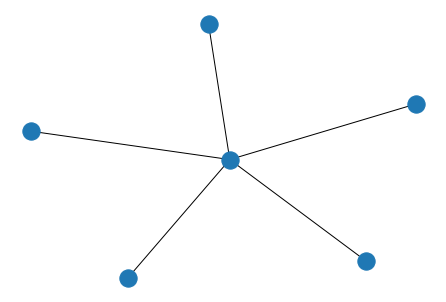

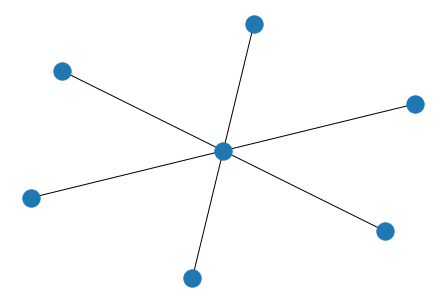

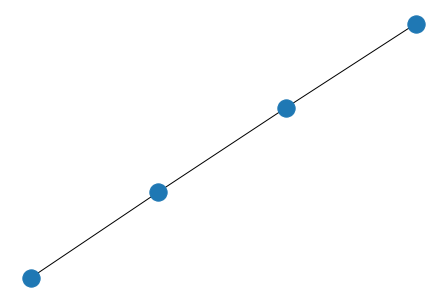

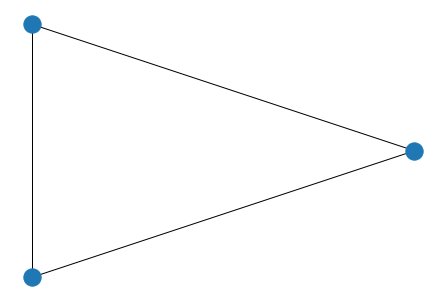

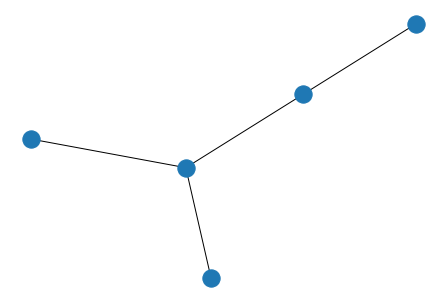

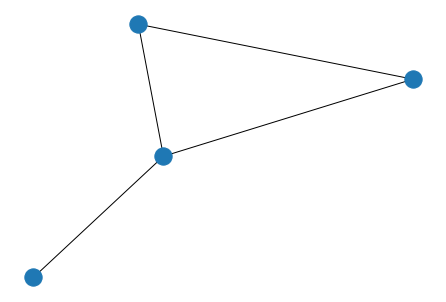

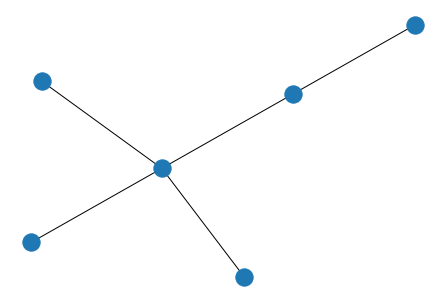

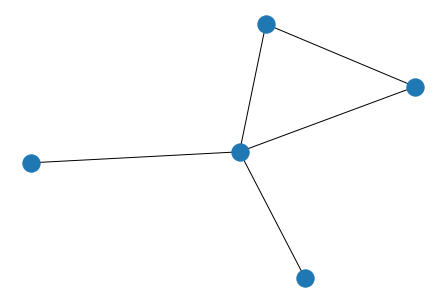

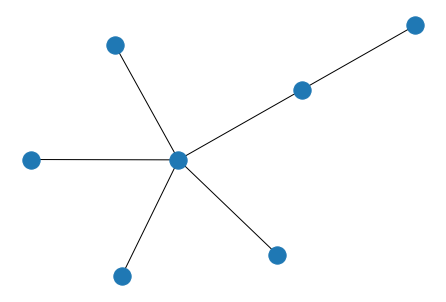

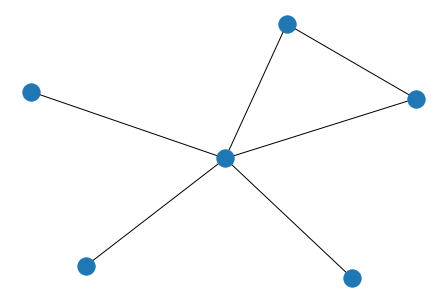

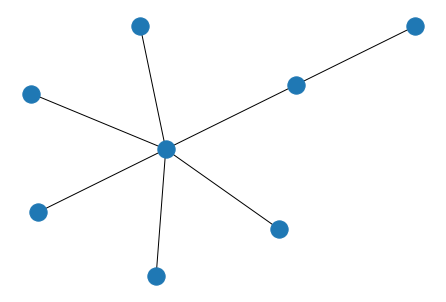

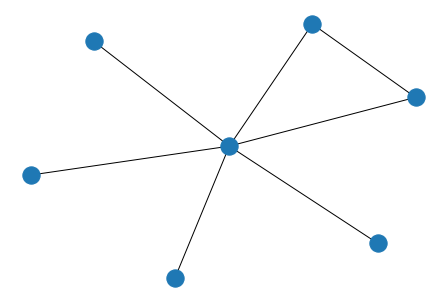

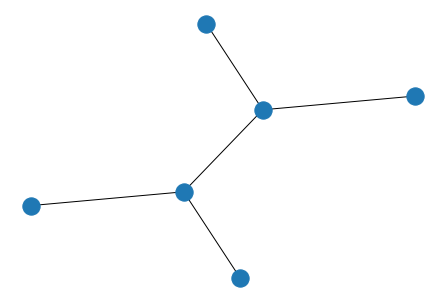

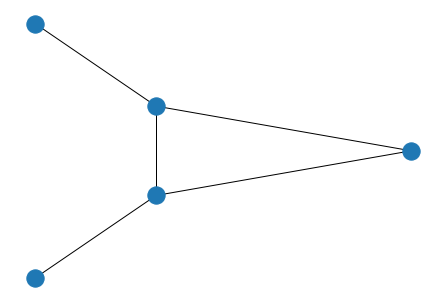

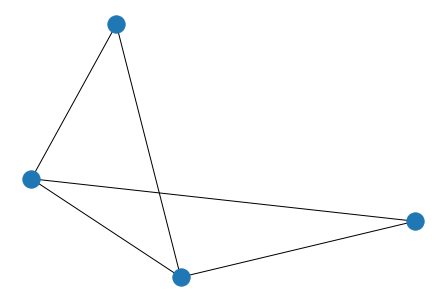

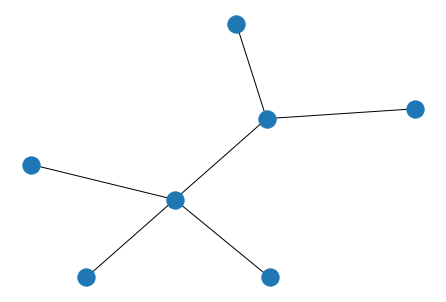

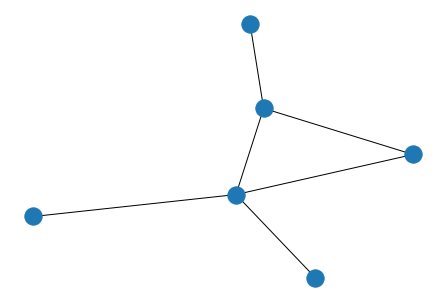

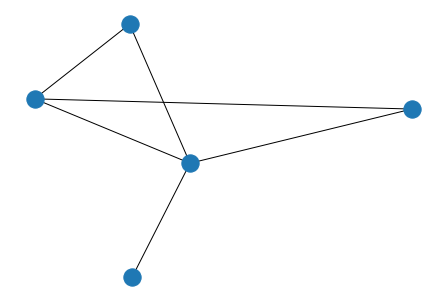

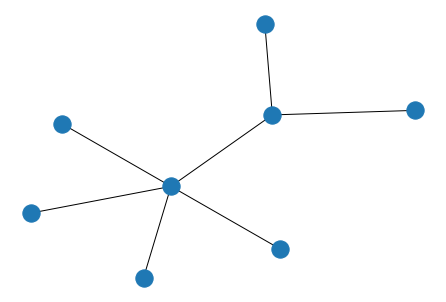

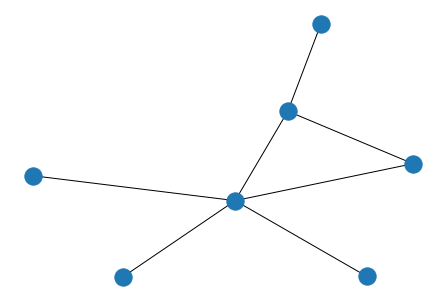

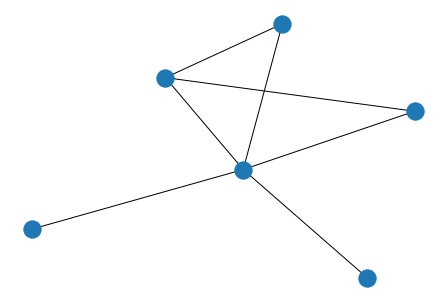

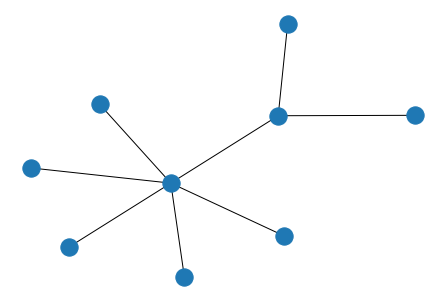

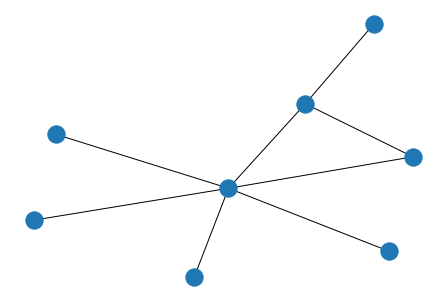

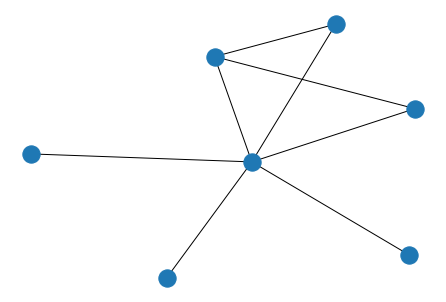

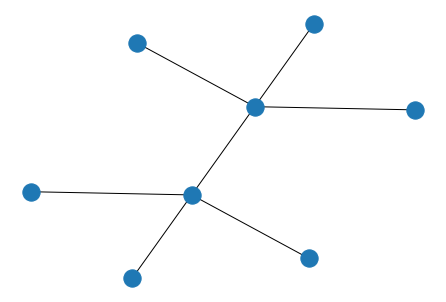

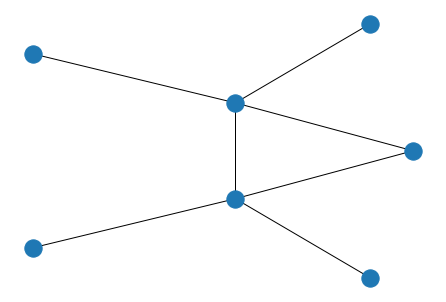

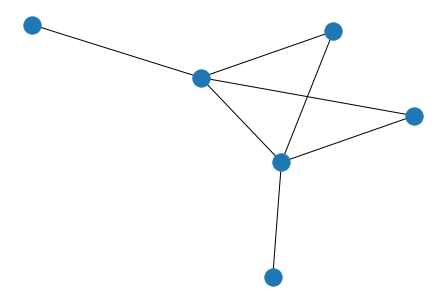

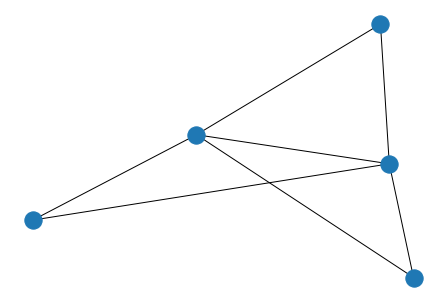

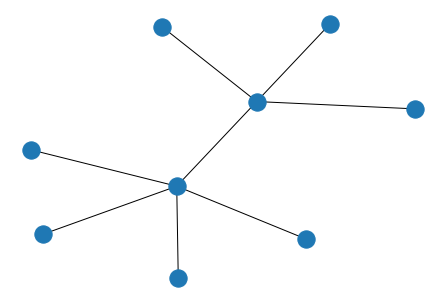

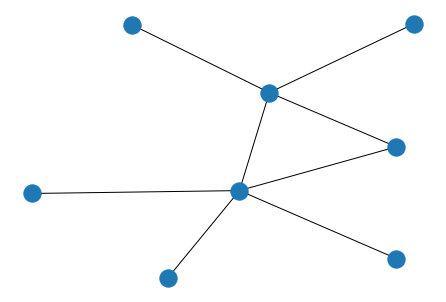

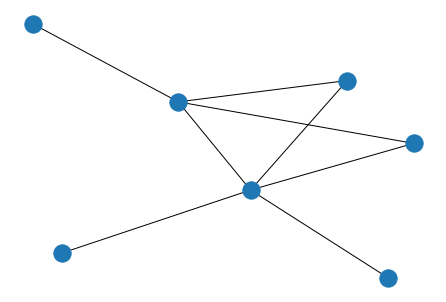

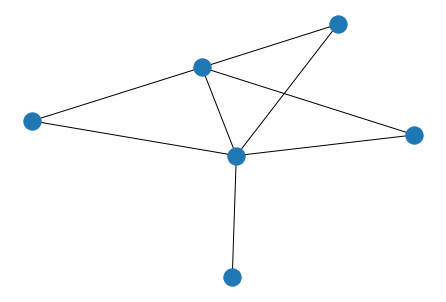

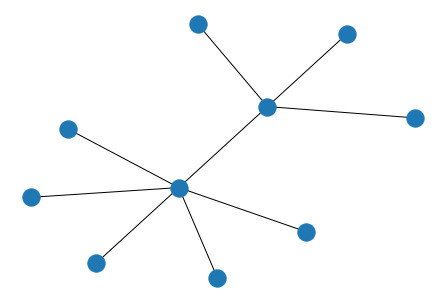

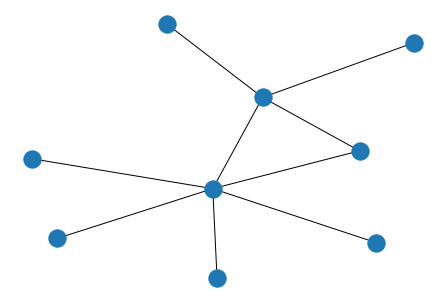

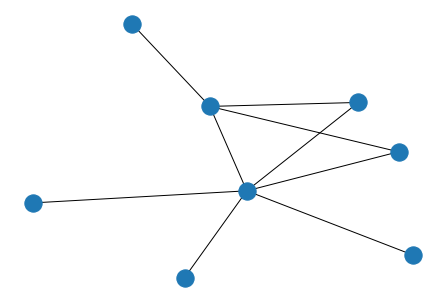

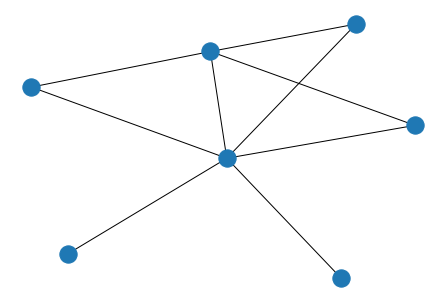

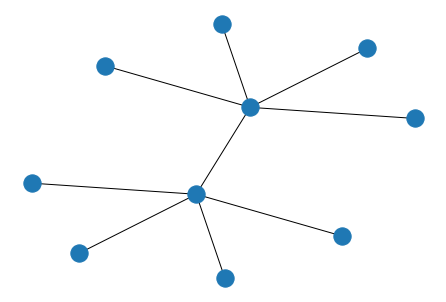

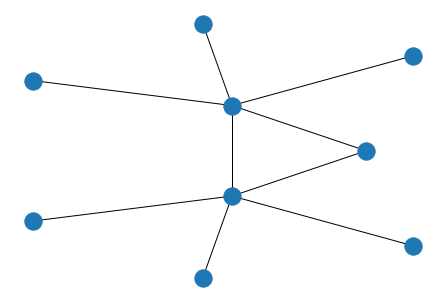

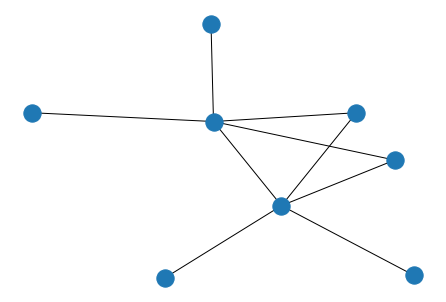

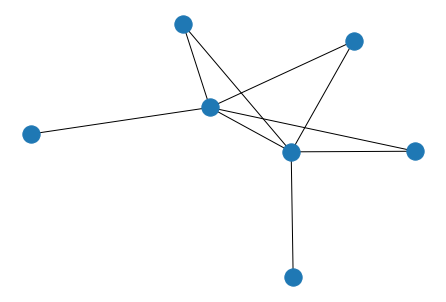

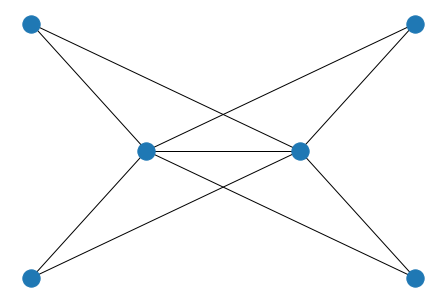

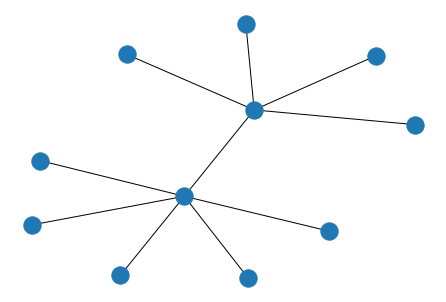

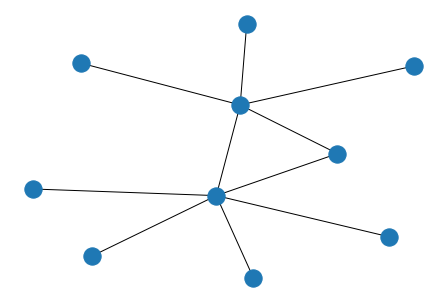

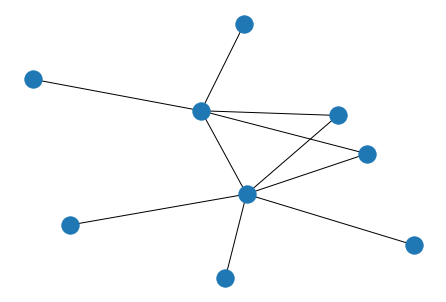

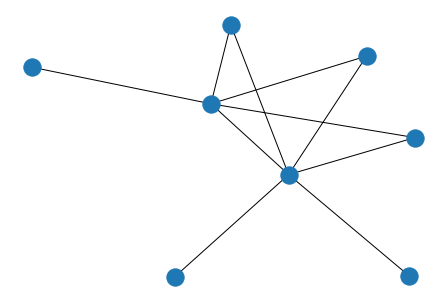

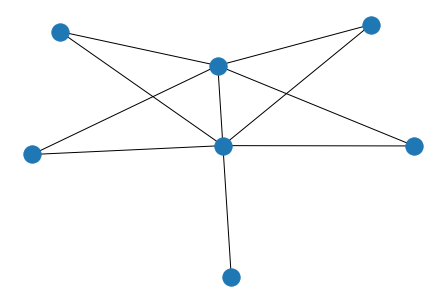

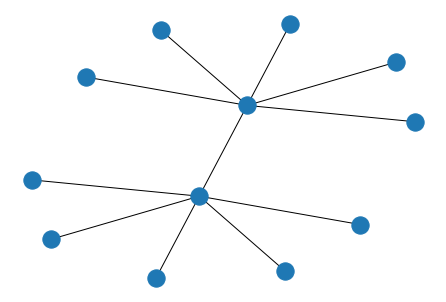

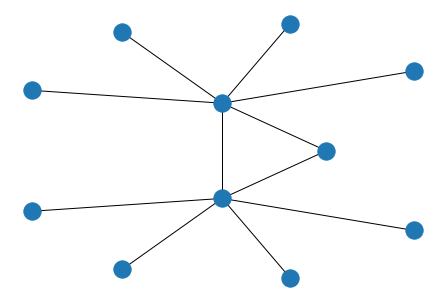

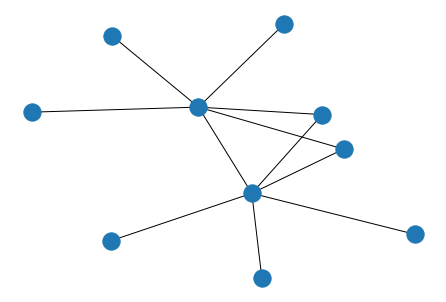

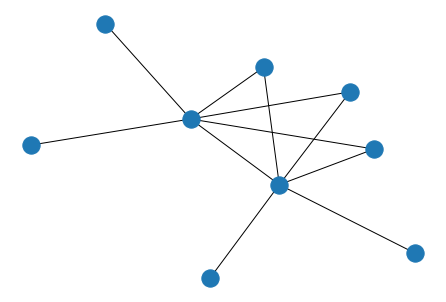

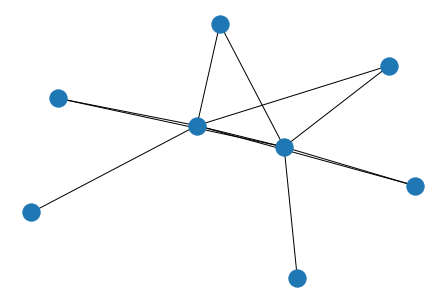

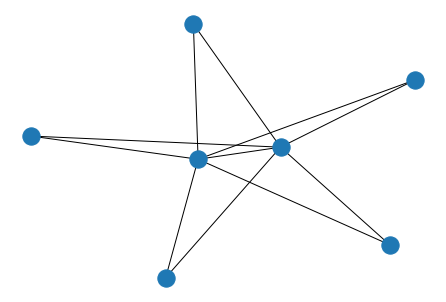

In [3]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [4]:
file1 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/transferability_matrix_random_subgraphs_6.txt")
file2 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/direct_transferability_matrix_random_subgraphs_6.txt")

In [5]:
tranf_mat_orig = np.loadtxt(file1).reshape(56,56)
tranf_mat_mod = np.loadtxt(file2).reshape(56,56)

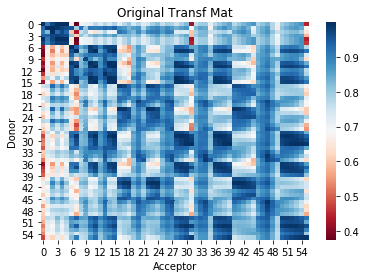

In [6]:
df = DataFrame(tranf_mat_orig)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Original Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

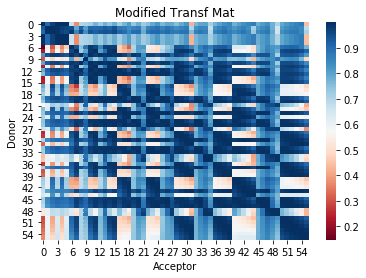

In [7]:
df = DataFrame(tranf_mat_mod)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Modified Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

# Identifying subgraphs of a graph

In [8]:

def find_index(g, subgraphs):
    """
    finds index of subgraph g is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(g, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs


# Similarity

In [9]:
##helper function for actual sim
def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

In [10]:
def similarity(G1, G2, subgraphs, tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
  metric = metric/total_arrows
  return metric


##** Different from that in other notebooks **

from qtensor import QAOA_energy

def actual_sim(G1, G2,g1_results, g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  transf_energy = QAOA_energy(G2, [donor_gamma], [donor_beta])
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim

def actual_sim_g_sub(G1, sub_G2,g1_results, sub_g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = sub_g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  loss = get_edge_contribution(graph = sub_G2, edge = (0,1), gamma = [donor_gamma], beta = [donor_beta])
  transf_energy = (1-loss)/2
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim

def mutual_similarity(G1, subgraphs , tranf_mat):
  """
  Compute subgraph similarity metric within a graph
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g1 = sub_g1_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g1:
      if (nx.is_isomorphic(donor, acceptor) is False):
        arrows = sub_g1_dict[donor]*sub_g1_dict[acceptor]
        i = find_index(donor, subgraphs)
        j = find_index(acceptor, subgraphs)
        metric+= arrows*tranf_mat[i,j]
        total_arrows += arrows
  metric = metric/total_arrows
  return metric


# Getting the graphs

In [11]:
g_data = []
with open('20NodeRandomData1.csv', 'r', newline = '') as s:
  spamreader = csv.reader(s, quotechar='|')
  for row in spamreader:
    new_row = [float(i) for i in row]
    g_data.append(new_row)

resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

g_list = mats_to_graphs(mat_list)

In [12]:
len(g_list)

55

In [13]:
len(g_data)

55

In [14]:
#sanity check whether graphs are isomorphic
for i in range(len(g_list)):
    g1 = g_list[i]
    for j in range(len(g_list)):
        if i!=j:
            g2 = g_list[j]
            if nx.is_isomorphic(g1,g2):
                print('####')
                print(i)
                print(j)

# Testing Aim

First get optimization data of subgraphs .. copied from July 6 file

In [16]:
subgraph_data = [[0.2500024437904358, 0.8750000596046448, 1.0000001788139343],
 [0.166666641831398, 0.37502503395080566, 0.8247596323490143],
 [0.6520434021949768, 0.12500910460948944, 0.7721655964851379],
 [0.7499753832817078, 0.1249999925494194, 0.7500000894069672],
 [0.7500015497207642, 0.1249999925494194, 0.7500000894069672],
 [0.24995003640651703, -0.1249999925494194, 0.7500000596046448],
 [0.3749999403953552, 0.6249989867210388, 0.7500000894069672],
 [0.5979562401771545, 0.4020429253578186, 0.6666667461395264],
 [-0.11072701960802078, 0.1249999925494194, 0.7174048572778702],
 [0.3442400097846985, 0.2110697478055954, 0.7049064934253693],
 [0.60235196352005, 0.8749914169311523, 0.6968001574277878],
 [0.4088258743286133, 0.6042372584342957, 0.649228572845459],
 [0.09668959677219391, 0.8750011920928955, 0.6820306926965714],
 [0.9103915095329285, 0.6064159870147705, 0.6430598348379135],
 [0.4073815643787384, 0.6250001192092896, 0.6707033067941666],
 [0.5890083312988281, 0.39171192049980164, 0.6379730105400085],
 [0.59795743227005, 0.625, 0.6924501359462738],
 [0.5873381495475769, 0.6046972274780273, 0.6466836184263229],
 [0.42177408933639526, 0.9100883603096008, 0.6162528097629547],
 [0.9096232056617737, 0.625, 0.6761299073696136],
 [0.08303678780794144, 0.8930931687355042, 0.6389948576688766],
 [0.39002183079719543, 0.2682580351829529, 0.6883674263954163],
 [0.5851007103919983, 0.625, 0.6641375720500946],
 [0.5799237489700317, 0.10859393328428268, 0.6328345090150833],
 [0.4256681501865387, 0.40524786710739136, 0.6092553958296776],
 [0.08114776760339737, 0.3749990165233612, 0.6547540724277496],
 [0.07758771628141403, 0.39003369212150574, 0.6277190744876862],
 [0.4034179151058197, 0.7988466024398804, 0.6352368295192719],
 [0.5833272933959961, 0.3749999403953552, 0.6623798310756683],
 [0.5780266523361206, 0.8913251161575317, 0.6315251886844635],
 [0.4274788498878479, 0.09507553279399872, 0.6083499118685722],
 [0.5658155679702759, 0.9155493974685669, 0.5905213356018066],
 [0.9215726852416992, 0.625, 0.6521333456039429],
 [0.9255304336547852, 0.11007045209407806, 0.6256206184625626],
 [0.4095125198364258, 0.7338758707046509, 0.6244720816612244],
 [0.5974558591842651, 0.2615016996860504, 0.6976248472929001],
 [0.4252829849720001, 0.12498827278614044, 0.6440232694149017],
 [0.4282618463039398, 0.11118073761463165, 0.6207438036799431],
 [0.0683182030916214, 0.9012623429298401, 0.6020957231521606],
 [0.0635281503200531, 0.911797821521759, 0.5869674384593964],
 [0.4261966347694397, 0.375, 0.6431084424257278],
 [0.42931705713272095, -0.1111898273229599, 0.6199876293540001],
 [0.5672296285629272, 0.5988389253616333, 0.6015077754855156],
 [0.56259685754776, 1.0884050130844116, 0.5865603759884834],
 [0.5574477910995483, 0.0802178680896759, 0.5746127218008041],
 [0.07027548551559448, 0.37499821186065674, 0.6359095126390457],
 [1.0678256750106812, 0.38788488507270813, 0.6153592318296432],
 [0.06501568853855133, 0.3996593654155731, 0.5985869765281677],
 [0.4190009534358978, 0.2599833905696869, 0.6429338455200195],
 [0.4107973277568817, 0.2581288814544678, 0.7047159373760223],
 [0.566938579082489, 0.8749993443489075, 0.6294021755456924],
 [0.4350946545600891, 0.612898051738739, 0.6109563186764717],
 [0.4374403953552246, 0.6016632914543152, 0.5956620052456856],
 [0.4406419098377228, 0.09167943894863129, 0.582893505692482],
 [0.4445511996746063, 0.5833631753921509, 0.5723293647170067],
 [0.44862493872642517, 1.0767524242401123, 0.5636934116482735]]

### Now comes analysis code

In [17]:
def add_subgraph_dicts(dicts):
    """
    helper function to ddecompose graphs; given a list of dicts, create one dict
    """
    master = {}
    for dicty in dicts:
        for key in dicty.keys():
            
            #check if subgraph already in master
            check_bool = False
            masters_iso_key = None
            
            for m_key in master.keys():
                if nx.is_isomorphic(m_key, key):
                    masters_iso_key = m_key
                    check_bool = True
                    break
            if check_bool:
                master[masters_iso_key]+= dicty[key]
            else:
                master[key] = dicty[key]
    return master

def decompose_graphs(graphs):
    """
    Return a dict of subgraphs and their frequencies in all graphs of the
    graph list
    """
    dicts = []
    for g in graphs:
        dicty = find_subgraphs(g)
        dicts.append(dicty)
    return add_subgraph_dicts(dicts)

In [18]:
def find_weighted_and_unweighted_sub_maxxed(donor, donor_results, acc_graphs, all_subs = g_all, all_sub_data = subgraph_data):
    """
    Given Acceptor graphs which were maximized by donor, this function now
    finds whether constituent subgraphs were also maximized.
    """
    master_subs = decompose_graphs(acc_graphs)
    new_master_subs={}
    unweighted_score = 0
    weighted_score = 0
    sub_maxxed = 0
    tot_subs=0
    tot_freqs =0
    
    
    for subgraph in master_subs.keys():
        tot_subs +=1
        tot_freqs+= master_subs[subgraph]
        
        ind = find_index(subgraph, all_subs)
        sim = actual_sim_g_sub(donor, all_subs[ind],donor_results, all_sub_data[ind])
        unweighted_score+= sim
        weighted_score+=sim*master_subs[subgraph]
        
        new_master_subs[subgraph] = (master_subs[subgraph], sim)
            
        
    unweighted_score = unweighted_score/tot_subs
    weighted_score = weighted_score/tot_freqs
    
    return unweighted_score, weighted_score, new_master_subs
        

In [36]:
def analysis(graph_list):
    """
    Given donor's best optima, find all acceptors it does not maximize, and whetehr it maximizes
    also their constituent subgraphs
    """
    n = len(graph_list)
    acc_maxxed = []
    unweighted_sub_maxxed = []
    weighted_sub_maxxed = []
    datas = []
    
    for i in range(n):
        print('####################################')
        g1 = graph_list[i]
        g1_results = g_data[i]
        g_maxxed = 0
        graphs_maxxed = []
        
        for k in range(n):
            g2 = graph_list[k]
            g2_results = g_data[k]
            sim = actual_sim(g1,g2,g1_results, g2_results)
            print(sim)
            if sim<0.98:
                g_maxxed+=1
                graphs_maxxed.append(g2)
        acc_maxxed.append(g_maxxed)
        #all subgraph data now3
        if g_maxxed !=0:
            unweighted_score, weighted_score, new_master_subs = find_weighted_and_unweighted_sub_maxxed(donor = g1, 
                                                    donor_results = g1_results, 
                                                    acc_graphs = graphs_maxxed)
            unweighted_sub_maxxed.append(unweighted_score)
            weighted_sub_maxxed.append(weighted_score)
            datas.append(new_master_subs)
        else:
            unweighted_sub_maxxed.append(0)
            weighted_sub_maxxed.append(0)
            #datas.append(new_master_subs)
        
    return acc_maxxed, unweighted_sub_maxxed, weighted_sub_maxxed, datas 

In [45]:
graph_list = g_list
acc_maxxed, unweighted_scores, weighted_scores, datas = analysis(graph_list)

####################################



[1.]



[0.99967582]



[0.99828077]



[0.99909269]



[0.99998229]



[0.99997803]



[0.99866432]



[0.99886003]



[0.99966144]



[0.99983019]



[0.99674298]



[0.99716669]



[0.99926487]



[0.9992387]



[0.99868035]



[0.99900539]



[0.99992334]



[0.99975154]



[0.99439428]



[0.99649746]



[0.99531817]



[0.9951649]



[0.9999291]



[0.99951842]



[0.9998761]



[0.99912984]



[0.99873531]



[0.99921652]



[0.99926381]



[0.99866147]



[0.99923891]



[0.99910568]



[0.99891782]



[0.99929712]



[0.99967527]



[0.99991098]



[0.99979387]



[0.99822427]



[0.9969908]



[0.9986811]



[0.9996568]



[0.99965451]



[0.99978711]



[0.99701336]



[0.99669528]



[0.99514891]



[0.99942146]



[0.99981073]



[0.99987877]



[0.99551134]



[0.99622217]



[0.99624643]



[0.99553404]



[0.9949671]



[0.99539153]
####################################



[0.99966933]



[1.]



[0.94958169]



[0.95827142]



[0.91742859]



[0.90296319]



[0.85458314]



[0.8516048]



[0.78900892]



[0.79794762]



[0.78606628]



[0.79226831]



[0.69775824]



[0.70255551]



[0.65501343]



[0.65357148]



[0.58278598]



[0.59192793]



[0.5823343]



[0.58185664]



[0.54620827]



[0.54924326]



[0.99984773]



[0.9999706]



[0.99994781]



[0.94920367]



[0.94974043]



[0.95857769]



[0.68804132]



[0.70952037]



[0.69323546]



[0.65364162]



[0.65686368]



[0.66041256]



[0.89278379]



[0.89981351]



[0.90676559]



[0.86890772]



[0.86783306]



[0.85878566]



[0.7878855]



[0.79310014]



[0.79255208]



[0.7889985]



[0.79132565]



[0.80312839]



[0.58818204]



[0.58560463]



[0.58792853]



[0.58990582]



[0.5774894]



[0.58340048]



[0.54130865]



[0.54444909]



[0.54544298]
####################################



[0.99814666]



[0.99919918]



[1.]



[0.99970909]



[0.99787498]



[0.99783787]



[0.99499664]



[0.99491034]



[0.99745879]



[0.99726584]



[0.9909879]



[0.99160358]



[0.99661666]



[0.99560543]



[0.9942569]



[0.9952343]



[0.99794643]



[0.99712887]



[0.98686809]



[0.99057819]



[0.98870159]



[0.98866461]



[0.99884859]



[0.99910944]



[0.99894786]



[0.99968567]



[0.99996278]



[0.99814594]



[0.9959883]



[0.99403528]



[0.99645312]



[0.99550974]



[0.995004]



[0.99587855]



[0.99902867]



[0.99863771]



[0.99864891]



[0.99310007]



[0.99080849]



[0.99504593]



[0.997386]



[0.99745635]



[0.99748846]



[0.99172356]



[0.99069102]



[0.98786957]



[0.99647998]



[0.99719385]



[0.99788558]



[0.9891635]



[0.98990588]



[0.99030778]



[0.98891632]



[0.98804362]



[0.98876059]
####################################



[0.99895867]



[0.99939446]



[0.99970777]



[1.]



[0.99881549]



[0.99879349]



[0.99556568]



[0.99574615]



[0.99791447]



[0.99803823]



[0.99204592]



[0.99276257]



[0.99699895]



[0.99647224]



[0.99554574]



[0.99613176]



[0.99889085]



[0.99790147]



[0.98895576]



[0.99177339]



[0.99005071]



[0.98974631]



[0.99944652]



[0.99916789]



[0.999387]



[0.99999954]



[0.99982122]



[0.99933631]



[0.99666254]



[0.99576397]



[0.9968803]



[0.99634117]



[0.99594789]



[0.99674961]



[0.99920765]



[0.99911222]



[0.99897502]



[0.99458066]



[0.99290046]



[0.99560694]



[0.99786459]



[0.99790473]



[0.99807846]



[0.99255827]



[0.99199276]



[0.98995942]



[0.99714328]



[0.99805928]



[0.99846767]



[0.99017884]



[0.99152137]



[0.99135787]



[0.99067671]



[0.98956067]



[0.99017806]
####################################



[0.99998159]



[0.99951004]



[0.99798707]



[0.99894034]



[1.]



[0.99999976]



[0.9986354]



[0.99889738]



[0.99958188]



[0.99982962]



[0.99686075]



[0.99731115]



[0.99918122]



[0.99927295]



[0.99883592]



[0.99906458]



[0.99997682]



[0.99975973]



[0.99477923]



[0.99666279]



[0.99553277]



[0.99531166]



[0.9998621]



[0.99931776]



[0.99976949]



[0.99898328]



[0.99847713]



[0.99928278]



[0.99925157]



[0.99890861]



[0.99916612]



[0.99914825]



[0.99898824]



[0.99935063]



[0.99950785]



[0.99981509]



[0.99966081]



[0.99842032]



[0.9973374]



[0.99865041]



[0.99958286]



[0.99957276]



[0.99974153]



[0.99707656]



[0.99687434]



[0.99552195]



[0.99939975]



[0.99984224]



[0.99984199]



[0.99562857]



[0.99649168]



[0.99637495]



[0.99585068]



[0.99522278]



[0.99562281]
####################################



[0.99997718]



[0.99948796]



[0.99794479]



[0.99891412]



[0.99999975]



[1.]



[0.99864066]



[0.99890913]



[0.99957539]



[0.99983103]



[0.99688828]



[0.99733993]



[0.99917704]



[0.99928248]



[0.99885959]



[0.99907769]



[0.99998041]



[0.99976277]



[0.99483646]



[0.99669542]



[0.99557302]



[0.99534601]



[0.99985052]



[0.99929258]



[0.99975409]



[0.99895781]



[0.99843985]



[0.99928135]



[0.99925588]



[0.99893935]



[0.99916342]



[0.9991592]



[0.99900289]



[0.99936165]



[0.99948645]



[0.99980215]



[0.99964433]



[0.99844994]



[0.99738372]



[0.99865538]



[0.99957713]



[0.99956605]



[0.99973818]



[0.99709768]



[0.99690788]



[0.99557652]



[0.99940181]



[0.99984708]



[0.99983868]



[0.99565931]



[0.99653425]



[0.99640477]



[0.99589877]



[0.99526765]



[0.99566439]
####################################



[0.99878513]



[0.99831167]



[0.99568789]



[0.99644204]



[0.99875464]



[0.99876115]



[1.]



[0.9999155]



[0.99959949]



[0.9994796]



[0.99933671]



[0.99931292]



[0.99984685]



[0.99985121]



[0.99936321]



[0.99982075]



[0.99862964]



[0.99961367]



[0.99671094]



[0.99898693]



[0.9982774]



[0.99859183]



[0.99834928]



[0.99837144]



[0.99847463]



[0.9965028]



[0.99636366]



[0.99646801]



[0.99991418]



[0.9984481]



[0.99988025]



[0.99985435]



[0.99979483]



[0.99975383]



[0.9984977]



[0.99878213]



[0.99884575]



[0.99918395]



[0.99779127]



[0.99999992]



[0.99962406]



[0.99959618]



[0.99954129]



[0.99957782]



[0.99903379]



[0.99715836]



[0.99988003]



[0.99945208]



[0.99945531]



[0.99889675]



[0.99819538]



[0.99909203]



[0.99750084]



[0.99789386]



[0.99819752]
####################################



[0.99892716]



[0.998158]



[0.99537549]



[0.99643571]



[0.99897998]



[0.99899425]



[0.99991367]



[1.]



[0.99952236]



[0.99960171]



[0.99946432]



[0.99954502]



[0.99971066]



[0.99996261]



[0.99974484]



[0.99998291]



[0.99897472]



[0.99974152]



[0.9974518]



[0.99924131]



[0.99860127]



[0.99872107]



[0.99842846]



[0.99811998]



[0.99845049]



[0.99650657]



[0.99610324]



[0.9969362]



[0.99992325]



[0.99909927]



[0.99976106]



[0.9999874]



[0.99997453]



[0.9999412]



[0.9983244]



[0.99875566]



[0.99872076]



[0.99961725]



[0.99856235]



[0.99991171]



[0.99955593]



[0.99951361]



[0.99955639]



[0.9995922]



[0.99931967]



[0.99789193]



[0.99988028]



[0.99965267]



[0.99951799]



[0.99895318]



[0.99872558]



[0.99923035]



[0.99814451]



[0.99830854]



[0.99857246]
####################################



[0.9996773]



[0.99953149]



[0.99774294]



[0.99828155]



[0.99959021]



[0.99958303]



[0.99958546]



[0.99952955]



[1.]



[0.99988886]



[0.9980104]



[0.99816991]



[0.99992112]



[0.99970502]



[0.99894558]



[0.99950362]



[0.9994101]



[0.99987431]



[0.99505303]



[0.99762342]



[0.9965785]



[0.99677148]



[0.99950764]



[0.99954265]



[0.99961124]



[0.99831913]



[0.99824357]



[0.99797729]



[0.9998274]



[0.99835805]



[0.99990458]



[0.99960298]



[0.99942597]



[0.99963327]



[0.99962925]



[0.9997644]



[0.99980109]



[0.99856832]



[0.99699358]



[0.99959675]



[0.99999933]



[0.99999991]



[0.99997557]



[0.9983618]



[0.99773015]



[0.99568737]



[0.99988882]



[0.99978633]



[0.99994017]



[0.99715699]



[0.99691913]



[0.99760872]



[0.99614477]



[0.99614078]



[0.99655086]
####################################



[0.99983251]



[0.99935457]



[0.99739909]



[0.99828036]



[0.99983456]



[0.99983611]



[0.99944823]



[0.99958172]



[0.99988988]



[1.]



[0.99809154]



[0.99836519]



[0.99973382]



[0.99979483]



[0.99932618]



[0.99963959]



[0.9997615]



[0.99998922]



[0.99580688]



[0.99783476]



[0.99685954]



[0.99683791]



[0.99959026]



[0.99925751]



[0.99957918]



[0.99832938]



[0.99795925]



[0.99850728]



[0.99980295]



[0.99904693]



[0.99973662]



[0.99970605]



[0.99958188]



[0.99979538]



[0.99942746]



[0.99972733]



[0.99965475]



[0.99900994]



[0.99781203]



[0.99945732]



[0.99989944]



[0.99988376]



[0.99996758]



[0.99831625]



[0.99798662]



[0.99644226]



[0.99986445]



[0.99998138]



[0.9999805]



[0.99715247]



[0.99743565]



[0.99769247]



[0.99677733]



[0.99652306]



[0.99688807]
####################################



[0.99701973]



[0.99577297]



[0.99207867]



[0.99352087]



[0.99718349]



[0.99721829]



[0.99933101]



[0.99948482]



[0.99805479]



[0.99824148]



[1.]



[0.99995742]



[0.99857516]



[0.99918379]



[0.99947572]



[0.99948877]



[0.99743149]



[0.99860522]



[0.99871169]



[0.9999313]



[0.99970953]



[0.99983849]



[0.99623481]



[0.9957237]



[0.99621881]



[0.99362253]



[0.99300825]



[0.99461324]



[0.99903288]



[0.9985619]



[0.99868599]



[0.99940554]



[0.99954293]



[0.99926004]



[0.99601304]



[0.99667367]



[0.99660796]



[0.99953222]



[0.99885241]



[0.99931759]



[0.99811954]



[0.99803686]



[0.99811035]



[0.9999536]



[0.99992601]



[0.99891403]



[0.99891732]



[0.99848201]



[0.99812407]



[0.99990542]



[0.99947643]



[0.9999763]



[0.99906704]



[0.99952061]



[0.99965154]
####################################



[0.997243]



[0.99586211]



[0.99216643]



[0.99376096]



[0.99744966]



[0.99748687]



[0.99927126]



[0.99952862]



[0.99809605]



[0.99839965]



[0.99995858]



[1.]



[0.99854567]



[0.99927195]



[0.99968422]



[0.99958156]



[0.99776144]



[0.99874137]



[0.99898936]



[0.99996083]



[0.99973902]



[0.99973904]



[0.99645235]



[0.99575044]



[0.99637355]



[0.99386529]



[0.99310468]



[0.99508961]



[0.99906776]



[0.99897393]



[0.99866002]



[0.99949044]



[0.99963934]



[0.99939298]



[0.99608271]



[0.99681073]



[0.99668448]



[0.99975071]



[0.99924539]



[0.99925801]



[0.99816274]



[0.99807581]



[0.99820919]



[0.99985969]



[0.99997948]



[0.99920955]



[0.99894836]



[0.9986702]



[0.99824972]



[0.99977217]



[0.99967979]



[0.99992253]



[0.99933083]



[0.99959682]



[0.99971846]
####################################



[0.99932049]



[0.99914863]



[0.99707322]



[0.9975876]



[0.99922647]



[0.99922169]



[0.99984344]



[0.99971386]



[0.99992405]



[0.99973637]



[0.99856037]



[0.99860789]



[1.]



[0.99978295]



[0.99903045]



[0.99962795]



[0.99902239]



[0.99977414]



[0.99551338]



[0.99814202]



[0.99720675]



[0.99751966]



[0.99906476]



[0.99921559]



[0.99921498]



[0.9976306]



[0.99762569]



[0.99724387]



[0.99991803]



[0.99821761]



[0.99999729]



[0.99971202]



[0.99956466]



[0.99966972]



[0.99929099]



[0.99943302]



[0.99951675]



[0.9987178]



[0.99709324]



[0.99985073]



[0.99993018]



[0.99992497]



[0.99985204]



[0.99890851]



[0.99821299]



[0.99607534]



[0.99993735]



[0.99963019]



[0.99977301]



[0.99789945]



[0.99730314]



[0.9982176]



[0.99652125]



[0.99675806]



[0.99714013]
####################################



[0.99927861]



[0.99857291]



[0.99601403]



[0.99704259]



[0.99932193]



[0.99933278]



[0.99985093]



[0.99996159]



[0.99970275]



[0.99980308]



[0.99915067]



[0.99929327]



[0.999787]



[1.]



[0.99972085]



[0.99996681]



[0.9992965]



[0.99989387]



[0.997096]



[0.99892333]



[0.9981889]



[0.99825601]



[0.99884812]



[0.99851227]



[0.99885431]



[0.99710762]



[0.99669713]



[0.99749479]



[0.9999673]



[0.99920448]



[0.9998247]



[0.99998781]



[0.99994527]



[0.99998387]



[0.99871215]



[0.99911514]



[0.99906345]



[0.99954613]



[0.9984712]



[0.99985193]



[0.9997299]



[0.9996947]



[0.99975479]



[0.99929921]



[0.99902701]



[0.99759444]



[0.99994956]



[0.99983303]



[0.99972761]



[0.99850972]



[0.99845925]



[0.99886716]



[0.99786219]



[0.99788951]



[0.99818034]
####################################



[0.99855451]



[0.99724639]



[0.99408164]



[0.99568462]



[0.9987578]



[0.99878708]



[0.99937103]



[0.99974211]



[0.99886678]



[0.99928156]



[0.99942767]



[0.99966164]



[0.99901099]



[0.99970858]



[1.]



[0.99985455]



[0.99899597]



[0.99946258]



[0.99850719]



[0.99943662]



[0.99896896]



[0.99877505]



[0.99791732]



[0.99704922]



[0.99776767]



[0.99577559]



[0.99491882]



[0.99702688]



[0.99948936]



[0.99974918]



[0.99909647]



[0.9998011]



[0.99988242]



[0.99983006]



[0.99739267]



[0.99809029]



[0.99789241]



[0.99997795]



[0.99951715]



[0.99936453]



[0.9989188]



[0.99884822]



[0.99905242]



[0.99935018]



[0.99954785]



[0.99889786]



[0.99941742]



[0.99948707]



[0.99910087]



[0.99886176]



[0.99937544]



[0.99924489]



[0.99900743]



[0.99883656]



[0.99901939]
####################################



[0.99897737]



[0.99809073]



[0.99526753]



[0.99645341]



[0.99906443]



[0.99908155]



[0.99981963]



[0.99998125]



[0.99946036]



[0.99962659]



[0.99943206]



[0.99956454]



[0.99961185]



[0.99996388]



[0.99985391]



[1.]



[0.99910926]



[0.99976339]



[0.99767497]



[0.99926296]



[0.99864155]



[0.9986725]



[0.99846033]



[0.99800859]



[0.9984367]



[0.99652782]



[0.99601181]



[0.99714887]



[0.99988198]



[0.9993374]



[0.99966788]



[0.9999942]



[0.99999743]



[0.99997613]



[0.99824568]



[0.99873565]



[0.998657]



[0.99974221]



[0.99882795]



[0.99981724]



[0.99949695]



[0.99944941]



[0.99953561]



[0.99951449]



[0.99935698]



[0.99811833]



[0.99983804]



[0.99970876]



[0.99951923]



[0.99887574]



[0.99887039]



[0.99919733]



[0.99833618]



[0.99838649]



[0.99863686]
####################################



[0.99991511]



[0.99928453]



[0.99767231]



[0.99878723]



[0.99997482]



[0.9999788]



[0.99845196]



[0.9988006]



[0.99939881]



[0.99974818]



[0.99679159]



[0.99729118]



[0.99896692]



[0.99919022]



[0.99889113]



[0.99900533]



[1.]



[0.99968316]



[0.99502512]



[0.9966534]



[0.99556055]



[0.99524288]



[0.99975719]



[0.99904339]



[0.9996122]



[0.99883582]



[0.99819289]



[0.9993803]



[0.99911508]



[0.9991009]



[0.99896161]



[0.99907276]



[0.9989391]



[0.99929995]



[0.9992719]



[0.99965767]



[0.99945359]



[0.99850696]



[0.99760092]



[0.99846573]



[0.99940494]



[0.9993869]



[0.9996048]



[0.99694707]



[0.99688543]



[0.99576575]



[0.99926369]



[0.99980127]



[0.999727]



[0.99552671]



[0.99662138]



[0.99630897]



[0.99603451]



[0.99529821]



[0.9956756]
####################################



[0.99973549]



[0.99918939]



[0.99707738]



[0.99800677]



[0.99975067]



[0.99975469]



[0.99957508]



[0.99970933]



[0.99987336]



[0.99998833]



[0.99838631]



[0.9986314]



[0.99977348]



[0.9998815]



[0.99946661]



[0.99975516]



[0.9996894]



[1.]



[0.99618]



[0.99814006]



[0.99722557]



[0.99721871]



[0.99944361]



[0.99909791]



[0.99943302]



[0.99806004]



[0.99767]



[0.99830741]



[0.99987543]



[0.99914235]



[0.9997855]



[0.99980954]



[0.99970701]



[0.99987779]



[0.99927828]



[0.99960926]



[0.99953827]



[0.9991891]



[0.99803415]



[0.99958206]



[0.99988756]



[0.99986668]



[0.999948]



[0.99858793]



[0.9982825]



[0.99678276]



[0.9999154]



[0.99998185]



[0.99994971]



[0.99751694]



[0.99773556]



[0.99801466]



[0.99709592]



[0.99690176]



[0.9972471]
####################################



[0.99405821]



[0.99159184]



[0.98686925]



[0.98953074]



[0.99458463]



[0.99465635]



[0.9965758]



[0.99735462]



[0.99473669]



[0.99566524]



[0.99871927]



[0.99899121]



[0.99531848]



[0.99693901]



[0.99854295]



[0.99769366]



[0.99565199]



[0.9962427]



[1.]



[0.99927245]



[0.99957705]



[0.99902576]



[0.99294347]



[0.99119499]



[0.99255091]



[0.98968135]



[0.98806136]



[0.99251787]



[0.99638715]



[0.99830109]



[0.99551446]



[0.99746877]



[0.99783588]



[0.99747198]



[0.99181422]



[0.99308017]



[0.99265732]



[0.99880401]



[0.99946513]



[0.99655157]



[0.99484629]



[0.99469436]



[0.99512468]



[0.99820289]



[0.9992315]



[0.99996129]



[0.99617856]



[0.99635807]



[0.99542811]



[0.99866225]



[0.99980621]



[0.9989352]



[0.9999655]



[0.99974972]



[0.9996827]
####################################



[0.99655592]



[0.99500928]



[0.99106036]



[0.9928005]



[0.99680627]



[0.99685018]



[0.99890647]



[0.99921022]



[0.99749723]



[0.9978624]



[0.99992688]



[0.99995675]



[0.99802842]



[0.99888456]



[0.99948617]



[0.99929002]



[0.99723079]



[0.99827322]



[0.99925334]



[1.]



[0.99990282]



[0.99987045]



[0.99568666]



[0.99487714]



[0.99558032]



[0.99291436]



[0.99205646]



[0.99435545]



[0.99863603]



[0.99873916]



[0.99816062]



[0.99917162]



[0.99936626]



[0.99905961]



[0.99524498]



[0.99605417]



[0.99590289]



[0.99959891]



[0.99924472]



[0.99889024]



[0.99757321]



[0.99747339]



[0.99763223]



[0.99976556]



[0.99999342]



[0.99940303]



[0.99849921]



[0.99820618]



[0.99770783]



[0.99984018]



[0.99978128]



[0.99995518]



[0.99950231]



[0.99980172]



[0.99988331]
####################################



[0.49149316]



[0.49502325]



[0.53462719]



[0.53856688]



[0.62912915]



[0.61739549]



[0.69262727]



[0.6898767]



[0.74475706]



[0.75274815]



[0.78403398]



[0.78961795]



[0.84676939]



[0.8526501]



[0.89266046]



[0.88896951]



[0.93112251]



[0.93790695]



[0.96758899]



[0.96040117]



[1.]



[0.99988412]



[0.49174825]



[0.4965588]



[0.49335567]



[0.53131338]



[0.53460994]



[0.53397028]



[0.83936385]



[0.86365837]



[0.8429356]



[0.88857422]



[0.89252373]



[0.89526932]



[0.61056922]



[0.61555632]



[0.622112]



[0.70459459]



[0.70284584]



[0.69644013]



[0.74416854]



[0.74854185]



[0.74813633]



[0.78668408]



[0.7894281]



[0.8012253]



[0.9337677]



[0.93305841]



[0.93273295]



[0.96522069]



[0.95996833]



[0.96048362]



[0.99967289]



[0.99997203]



[0.99999173]
####################################



[0.48981287]



[0.49368539]



[0.53361556]



[0.53746322]



[0.62874906]



[0.61657429]



[0.69233889]



[0.68933347]



[0.7446694]



[0.75276471]



[0.78398098]



[0.78966209]



[0.84716304]



[0.8529973]



[0.89265676]



[0.88906429]



[0.93087644]



[0.93813645]



[0.96715291]



[0.96021747]



[0.99988306]



[1.]



[0.4901303]



[0.49534255]



[0.49186455]



[0.52993137]



[0.53354452]



[0.53235313]



[0.83933144]



[0.86386097]



[0.84317078]



[0.888686]



[0.89272742]



[0.89556341]



[0.60983443]



[0.6148809]



[0.62175658]



[0.70429506]



[0.70221702]



[0.69629183]



[0.74404825]



[0.74859644]



[0.74808357]



[0.7868305]



[0.78941911]



[0.80125207]



[0.93398931]



[0.93302953]



[0.93285552]



[0.9654634]



[0.95945789]



[0.96044206]



[0.99916424]



[0.99975261]



[0.99981231]
####################################



[0.99992668]



[0.99984993]



[0.94935731]



[0.95812449]



[0.91689169]



[0.90296702]



[0.85435565]



[0.85166964]



[0.78891731]



[0.79772802]



[0.78606517]



[0.79214868]



[0.69775126]



[0.70258879]



[0.6557162]



[0.65415154]



[0.58398793]



[0.59266108]



[0.58382205]



[0.58303617]



[0.54754898]



[0.55034243]



[1.]



[0.99970067]



[0.99997045]



[0.94940604]



[0.94959837]



[0.95899087]



[0.68851236]



[0.70975638]



[0.69340659]



[0.65419489]



[0.6573431]



[0.66076884]



[0.89268598]



[0.8996327]



[0.90622179]



[0.86870016]



[0.86798138]



[0.85840594]



[0.78784752]



[0.7928574]



[0.79242527]



[0.78879192]



[0.79128728]



[0.80305601]



[0.58896335]



[0.58661676]



[0.5887481]



[0.59064348]



[0.57901913]



[0.58443987]



[0.54303653]



[0.54591228]



[0.54684599]
####################################



[0.99951107]



[0.99997031]



[0.94961639]



[0.95826527]



[0.91757128]



[0.90292666]



[0.85460199]



[0.85151271]



[0.78893258]



[0.79791416]



[0.78595257]



[0.79219486]



[0.69764993]



[0.70241593]



[0.65461793]



[0.65322062]



[0.58201853]



[0.59141253]



[0.58132444]



[0.58096767]



[0.54525595]



[0.5484156]



[0.99969622]



[1.]



[0.99985534]



[0.94908865]



[0.94976366]



[0.95834767]



[0.68773602]



[0.70932485]



[0.69305454]



[0.65329569]



[0.65657183]



[0.66015177]



[0.89277312]



[0.89982605]



[0.90691962]



[0.8689314]



[0.86770513]



[0.85887057]



[0.78780245]



[0.79309229]



[0.79249394]



[0.78898438]



[0.79123749]



[0.80305943]



[0.58768632]



[0.58496393]



[0.58735072]



[0.58923654]



[0.5764344]



[0.5825898]



[0.54014222]



[0.54344993]



[0.54445697]
####################################



[0.99987467]



[0.99994847]



[0.94949314]



[0.9582221]



[0.91712616]



[0.90299504]



[0.85443574]



[0.85162948]



[0.78889232]



[0.79775224]



[0.7859934]



[0.79212277]



[0.6976563]



[0.70246699]



[0.65530211]



[0.65378712]



[0.58323271]



[0.59214585]



[0.58285728]



[0.58220186]



[0.54663337]



[0.54954753]



[0.99997032]



[0.99985678]



[1.]



[0.94937463]



[0.94971284]



[0.95885195]



[0.6882106]



[0.70956372]



[0.69323511]



[0.65383826]



[0.65703314]



[0.66049977]



[0.89274718]



[0.89972318]



[0.90646395]



[0.8687803]



[0.86790487]



[0.85855393]



[0.78780899]



[0.79290164]



[0.79241783]



[0.78881832]



[0.79123799]



[0.80302466]



[0.58845233]



[0.58597429]



[0.58817889]



[0.59002428]



[0.57801917]



[0.58367931]



[0.54191844]



[0.54494574]



[0.54589827]
####################################



[0.99899485]



[0.99940586]



[0.99968631]



[0.99999948]



[0.99885636]



[0.99883491]



[0.99561869]



[0.99580616]



[0.99794937]



[0.99808167]



[0.99212948]



[0.99284532]



[0.99703784]



[0.99652931]



[0.99561693]



[0.99618996]



[0.99892924]



[0.99794472]



[0.98907386]



[0.99186045]



[0.99014765]



[0.98983819]



[0.99947053]



[0.99917668]



[0.99940706]



[1.]



[0.99980755]



[0.99936789]



[0.9967127]



[0.9958447]



[0.99692138]



[0.99639651]



[0.99600836]



[0.99680346]



[0.99922095]



[0.99913691]



[0.9989962]



[0.99466316]



[0.9930037]



[0.99565945]



[0.99790058]



[0.99793952]



[0.99811628]



[0.99263333]



[0.99208255]



[0.99007503]



[0.99718878]



[0.9981038]



[0.99850095]



[0.99026836]



[0.99161904]



[0.99144309]



[0.99077982]



[0.98966354]



[0.99027621]
####################################



[0.99864993]



[0.99950456]



[0.99996237]



[0.99982058]



[0.99840833]



[0.99837495]



[0.9957823]



[0.99572458]



[0.99802334]



[0.99786769]



[0.99207114]



[0.99264491]



[0.99725066]



[0.99637462]



[0.99510688]



[0.99600113]



[0.9984181]



[0.99772435]



[0.98816583]



[0.99166517]



[0.98988437]



[0.98984887]



[0.99922854]



[0.99941521]



[0.99931406]



[0.9998053]



[1.]



[0.99848406]



[0.99670841]



[0.99491296]



[0.9971074]



[0.99625273]



[0.9957919]



[0.99658717]



[0.99936444]



[0.99906067]



[0.99906172]



[0.99406783]



[0.99191267]



[0.99582627]



[0.99796038]



[0.99802155]



[0.99805827]



[0.99274287]



[0.99179746]



[0.98913813]



[0.99714178]



[0.99778152]



[0.99838488]



[0.99034056]



[0.99103131]



[0.99140917]



[0.99007313]



[0.98926743]



[0.98994205]
####################################



[0.99909014]



[0.99862945]



[0.99820678]



[0.99934977]



[0.99914543]



[0.99914581]



[0.99545459]



[0.99602874]



[0.99758415]



[0.99817509]



[0.99271581]



[0.99358591]



[0.99659437]



[0.99677578]



[0.99650779]



[0.99651889]



[0.9993107]



[0.99805724]



[0.99117276]



[0.99267882]



[0.99120849]



[0.99050581]



[0.99927208]



[0.99819968]



[0.99897817]



[0.99938286]



[0.9985369]



[1.]



[0.99668465]



[0.99733807]



[0.99654081]



[0.99663157]



[0.9964024]



[0.99710162]



[0.99842509]



[0.99876042]



[0.99840392]



[0.99580934]



[0.99502735]



[0.99548444]



[0.99756758]



[0.99756325]



[0.99794723]



[0.99290125]



[0.99302356]



[0.99214951]



[0.99713111]



[0.99835327]



[0.99834867]



[0.99080952]



[0.99304839]



[0.9920465]



[0.99244671]



[0.99096498]



[0.99143713]
####################################



[0.99931498]



[0.99881227]



[0.99641751]



[0.9972465]



[0.99930445]



[0.99930949]



[0.99991214]



[0.99992428]



[0.99982774]



[0.99981098]



[0.99900792]



[0.99910461]



[0.99991954]



[0.99996713]



[0.99950456]



[0.999889]



[0.99920401]



[0.99988476]



[0.9965623]



[0.99870277]



[0.9978986]



[0.99807028]



[0.99894448]



[0.99880531]



[0.99900991]



[0.99730352]



[0.99705477]



[0.99738955]



[1.]



[0.99885738]



[0.99994287]



[0.99993296]



[0.99985261]



[0.99990822]



[0.99895594]



[0.99925922]



[0.99926349]



[0.99928267]



[0.9979922]



[0.99991523]



[0.99984738]



[0.99982322]



[0.99982813]



[0.99923296]



[0.99879262]



[0.9970809]



[0.99999419]



[0.9997873]



[0.99977639]



[0.99837363]



[0.99808326]



[0.99870481]



[0.99741279]



[0.99754085]



[0.99786444]
####################################



[0.99854832]



[0.99697793]



[0.99394087]



[0.9958618]



[0.99883543]



[0.99886904]



[0.99851483]



[0.99912177]



[0.99836016]



[0.99903959]



[0.99847607]



[0.99891938]



[0.99828904]



[0.99922568]



[0.99975334]



[0.99935889]



[0.99918951]



[0.99916327]



[0.99822497]



[0.9986297]



[0.99811361]



[0.99761634]



[0.9979309]



[0.99663393]



[0.99763707]



[0.99595652]



[0.99477733]



[0.99769877]



[0.99889436]



[1.]



[0.99837697]



[0.9992941]



[0.99938926]



[0.99944591]



[0.99706216]



[0.9978942]



[0.99755658]



[0.99972522]



[0.99963711]



[0.99851018]



[0.99841388]



[0.99833627]



[0.99867974]



[0.99829309]



[0.9988126]



[0.99868701]



[0.99885219]



[0.99931283]



[0.99880376]



[0.997647]



[0.99896727]



[0.99823789]



[0.99871217]



[0.99807976]



[0.99825283]
####################################



[0.9992962]



[0.99906962]



[0.99692103]



[0.99748355]



[0.99921477]



[0.99921176]



[0.99987875]



[0.99976578]



[0.99990702]



[0.99974039]



[0.99867854]



[0.99872484]



[0.99999744]



[0.99982243]



[0.99911638]



[0.99968315]



[0.99902444]



[0.99978814]



[0.99571962]



[0.9982753]



[0.99736941]



[0.99766953]



[0.99901531]



[0.99912928]



[0.99915578]



[0.99752924]



[0.99749119]



[0.99721414]



[0.99994229]



[0.99831194]



[1.]



[0.99975958]



[0.99962531]



[0.99971422]



[0.9992156]



[0.99938385]



[0.99945871]



[0.99882333]



[0.99724793]



[0.99988505]



[0.99991585]



[0.99990715]



[0.99984271]



[0.99900682]



[0.99834677]



[0.99626921]



[0.99995477]



[0.99964707]



[0.99976455]



[0.99803703]



[0.99746042]



[0.99834649]



[0.99669522]



[0.99693429]



[0.99730478]
####################################



[0.99909178]



[0.99828902]



[0.99556916]



[0.99667856]



[0.9991576]



[0.99917197]



[0.99985455]



[0.99998628]



[0.999569]



[0.9996981]



[0.99934186]



[0.99947042]



[0.99970079]



[0.99998684]



[0.99979788]



[0.99999436]



[0.99916799]



[0.99981778]



[0.99743698]



[0.99914294]



[0.99847674]



[0.99853416]



[0.99860922]



[0.99822136]



[0.99860333]



[0.99674898]



[0.99628848]



[0.99725565]



[0.99992931]



[0.99926315]



[0.99974923]



[1.]



[0.99998394]



[0.99998297]



[0.9984399]



[0.99888917]



[0.99882693]



[0.99966098]



[0.99866672]



[0.99985347]



[0.99960167]



[0.99955947]



[0.99962959]



[0.99945537]



[0.99923858]



[0.99790057]



[0.99989497]



[0.99975582]



[0.99960534]



[0.99876065]



[0.99870588]



[0.99908885]



[0.99814132]



[0.99819979]



[0.99846711]
####################################



[0.99888549]



[0.99794714]



[0.99505304]



[0.99628486]



[0.99898545]



[0.99900435]



[0.9997953]



[0.99997316]



[0.99938077]



[0.99956763]



[0.99949338]



[0.99962521]



[0.99954911]



[0.99994136]



[0.99988097]



[0.99999736]



[0.99905247]



[0.99971724]



[0.99782473]



[0.99934228]



[0.99875183]



[0.99876986]



[0.99834525]



[0.99785763]



[0.99831204]



[0.99636189]



[0.99581395]



[0.99705145]



[0.99984501]



[0.99936818]



[0.99961017]



[0.99998409]



[1.]



[0.99996341]



[0.99810578]



[0.99862075]



[0.99853334]



[0.99978588]



[0.99891913]



[0.99979201]



[0.99941996]



[0.99936894]



[0.99946371]



[0.99955674]



[0.99943373]



[0.99825311]



[0.99979433]



[0.99966553]



[0.99945192]



[0.99895814]



[0.99897309]



[0.99927208]



[0.99845762]



[0.99850981]



[0.99874901]
####################################



[0.99925754]



[0.99841931]



[0.99577863]



[0.99694222]



[0.99933745]



[0.99935187]



[0.99975426]



[0.99993775]



[0.99959589]



[0.9997816]



[0.99916175]



[0.99934602]



[0.9996604]



[0.99998347]



[0.99982554]



[0.99997554]



[0.99936505]



[0.99987816]



[0.99737638]



[0.99898968]



[0.99829105]



[0.99827671]



[0.99879551]



[0.99831753]



[0.99875773]



[0.99701199]



[0.99648703]



[0.99760379]



[0.99990583]



[0.9994187]



[0.99970626]



[0.99998289]



[0.99996243]



[1.]



[0.99855148]



[0.99902005]



[0.99892653]



[0.99967601]



[0.99874929]



[0.99975427]



[0.99962735]



[0.99958545]



[0.99968694]



[0.99925977]



[0.99910565]



[0.99786822]



[0.99988343]



[0.99984727]



[0.99968006]



[0.99849765]



[0.99864249]



[0.99888577]



[0.99809563]



[0.99803159]



[0.99830349]
####################################



[0.99966884]



[0.99999001]



[0.99913842]



[0.99933156]



[0.99949724]



[0.99947559]



[0.99843919]



[0.99834528]



[0.99962789]



[0.99945154]



[0.99591095]



[0.99621796]



[0.99926636]



[0.99872496]



[0.99765436]



[0.99840027]



[0.99931725]



[0.99934434]



[0.9924104]



[0.99547162]



[0.99409095]



[0.99423372]



[0.99981113]



[0.99998491]



[0.9999313]



[0.99934351]



[0.99943748]



[0.99849898]



[0.99895348]



[0.99721707]



[0.99919304]



[0.99857283]



[0.99826375]



[0.99871636]



[1.]



[0.99992277]



[0.99996822]



[0.99701671]



[0.99512606]



[0.99846377]



[0.99959878]



[0.99963037]



[0.9996052]



[0.99641947]



[0.99559584]



[0.99320271]



[0.9991449]



[0.99930146]



[0.99966809]



[0.99469577]



[0.99474118]



[0.99538153]



[0.99386005]



[0.99356057]



[0.9940912]
####################################



[0.99991077]



[0.99991263]



[0.99875741]



[0.99924949]



[0.99981262]



[0.9997996]



[0.99869956]



[0.99873705]



[0.99975632]



[0.99973777]



[0.99649926]



[0.99684814]



[0.99939516]



[0.99910505]



[0.99827883]



[0.99882489]



[0.99967853]



[0.99964647]



[0.99354454]



[0.99614666]



[0.99487539]



[0.99489003]



[0.99993656]



[0.99984103]



[0.99997862]



[0.99927432]



[0.9991394]



[0.9988784]



[0.99923573]



[0.99802218]



[0.99934672]



[0.99896054]



[0.99871409]



[0.99911767]



[0.99992353]



[1.]



[0.99997261]



[0.9977413]



[0.99616416]



[0.99871974]



[0.99973999]



[0.99975454]



[0.9997994]



[0.99689125]



[0.99630527]



[0.99431243]



[0.99940363]



[0.99964599]



[0.99986524]



[0.99529835]



[0.99562058]



[0.99599007]



[0.99483008]



[0.99443105]



[0.99490643]
####################################



[0.9997925]



[0.99993892]



[0.99881263]



[0.99914844]



[0.99965526]



[0.99963849]



[0.99880801]



[0.99875167]



[0.99980187]



[0.9996746]



[0.99655692]



[0.99684078]



[0.99950026]



[0.99908633]



[0.9981327]



[0.99879303]



[0.9994774]



[0.99958654]



[0.99329407]



[0.99614558]



[0.99486021]



[0.9949857]



[0.99983922]



[0.999923]



[0.99993852]



[0.99916871]



[0.99917452]



[0.99853477]



[0.99926939]



[0.99770879]



[0.99944486]



[0.99894175]



[0.99867507]



[0.99906339]



[0.99996876]



[0.99997248]



[1.]



[0.99757735]



[0.99582551]



[0.99882862]



[0.99978177]



[0.99980307]



[0.99979315]



[0.99700505]



[0.99627606]



[0.99404908]



[0.99942492]



[0.99954332]



[0.99983012]



[0.99542172]



[0.99546688]



[0.99605713]



[0.99462779]



[0.99436942]



[0.99486161]
####################################



[0.99817808]



[0.99672841]



[0.99336338]



[0.99509229]



[0.99841826]



[0.99845256]



[0.99920587]



[0.99962144]



[0.99853676]



[0.99900827]



[0.99951265]



[0.99974456]



[0.99873445]



[0.99954265]



[0.99997922]



[0.999752]



[0.99873312]



[0.9992304]



[0.99884191]



[0.99957706]



[0.99920075]



[0.99897139]



[0.9974775]



[0.99651093]



[0.99730158]



[0.99519057]



[0.99424632]



[0.99662974]



[0.99928393]



[0.9997291]



[0.99883387]



[0.99967765]



[0.99979429]



[0.99969924]



[0.99688588]



[0.99765218]



[0.99743025]



[1.]



[0.99967014]



[0.99919694]



[0.998596]



[0.99851566]



[0.99874359]



[0.99938257]



[0.99967541]



[0.999185]



[0.99919212]



[0.99926267]



[0.99881037]



[0.99901119]



[0.99957969]



[0.99937307]



[0.99926828]



[0.99910424]



[0.99925599]
####################################



[0.99682744]



[0.99477811]



[0.99091353]



[0.99323845]



[0.99724027]



[0.99729211]



[0.99789781]



[0.99861643]



[0.99698252]



[0.99781327]



[0.99888925]



[0.99927142]



[0.99719353]



[0.99849618]



[0.99954254]



[0.99889577]



[0.99790121]



[0.99811885]



[0.9994495]



[0.99923659]



[0.99910119]



[0.99854384]



[0.99596032]



[0.9943934]



[0.9956021]



[0.99336034]



[0.99192648]



[0.99570134]



[0.99804086]



[0.99964671]



[0.99733461]



[0.99875319]



[0.99898117]



[0.99884528]



[0.99492625]



[0.99598878]



[0.99559419]



[0.99967732]



[1.]



[0.99788328]



[0.99706363]



[0.9969502]



[0.99734962]



[0.99852992]



[0.99933527]



[0.99969314]



[0.9979022]



[0.99826656]



[0.99753368]



[0.99839213]



[0.99971967]



[0.99884815]



[0.99967045]



[0.9991811]



[0.99923657]
####################################



[0.99879852]



[0.99833323]



[0.99572192]



[0.99646909]



[0.99876614]



[0.99877235]



[0.99999992]



[0.99991338]



[0.99960966]



[0.99948706]



[0.999322]



[0.99929903]



[0.9998537]



[0.99985183]



[0.99935627]



[0.99981816]



[0.99863831]



[0.99961884]



[0.99668331]



[0.99896983]



[0.99825498]



[0.99857064]



[0.9983668]



[0.9983938]



[0.99849335]



[0.9965294]



[0.99639478]



[0.99648426]



[0.99991695]



[0.99844186]



[0.99988623]



[0.99985302]



[0.99979134]



[0.99975337]



[0.9985185]



[0.998799]



[0.99886369]



[0.99917402]



[0.99777429]



[1.]



[0.99963379]



[0.99960649]



[0.99955056]



[0.99956609]



[0.99901712]



[0.99713332]



[0.99988387]



[0.99945715]



[0.99946419]



[0.99887774]



[0.99817554]



[0.99907505]



[0.99747836]



[0.9978695]



[0.99817507]
####################################



[0.99967336]



[0.99950008]



[0.99767452]



[0.9982371]



[0.99959245]



[0.99958612]



[0.99961051]



[0.99956279]



[0.99999933]



[0.99989853]



[0.99807622]



[0.998235]



[0.9999275]



[0.99973234]



[0.99899508]



[0.99953789]



[0.99941787]



[0.99988819]



[0.99516213]



[0.9976963]



[0.99666568]



[0.99685245]



[0.99949089]



[0.99950775]



[0.99958971]



[0.99827599]



[0.99818402]



[0.99796983]



[0.99984709]



[0.99841253]



[0.99991358]



[0.99963351]



[0.99946294]



[0.99966218]



[0.99959977]



[0.999748]



[0.99978036]



[0.99862813]



[0.99707776]



[0.9996213]



[1.]



[0.99999889]



[0.99997864]



[0.99841775]



[0.99780362]



[0.99579068]



[0.99990464]



[0.99980161]



[0.99994277]



[0.99723227]



[0.99700391]



[0.99767948]



[0.99623764]



[0.99623473]



[0.99663907]
####################################



[0.99967099]



[0.99953531]



[0.99775361]



[0.99828211]



[0.99958128]



[0.99957383]



[0.99958412]



[0.99952303]



[0.99999991]



[0.99988265]



[0.99800076]



[0.99815758]



[0.9999224]



[0.99969801]



[0.99892991]



[0.99949502]



[0.99939829]



[0.99986772]



[0.9950239]



[0.99761015]



[0.9965625]



[0.99676111]



[0.99950408]



[0.99954935]



[0.9996108]



[0.99831931]



[0.99825211]



[0.99796219]



[0.99982373]



[0.99833452]



[0.99990519]



[0.99959546]



[0.99941668]



[0.99962445]



[0.99963352]



[0.99976369]



[0.99980335]



[0.99855036]



[0.99696467]



[0.99959551]



[0.99999889]



[1.]



[0.99997274]



[0.99835598]



[0.9977157]



[0.99565861]



[0.99988543]



[0.99977771]



[0.99993626]



[0.99714873]



[0.99689759]



[0.99759869]



[0.99611986]



[0.99612181]



[0.99653342]
####################################



[0.99979688]



[0.99951114]



[0.99768131]



[0.99836962]



[0.99974862]



[0.99974497]



[0.99951421]



[0.99954719]



[0.99997566]



[0.99996744]



[0.99800179]



[0.99822176]



[0.99984708]



[0.99975011]



[0.9991146]



[0.99956353]



[0.99961589]



[0.99994926]



[0.995342]



[0.99767345]



[0.99664683]



[0.99673538]



[0.99960494]



[0.99947006]



[0.99965448]



[0.99841159]



[0.99820223]



[0.99829763]



[0.99982215]



[0.99868271]



[0.99983745]



[0.99965026]



[0.99949298]



[0.99971332]



[0.99959339]



[0.99979861]



[0.99978352]



[0.99875684]



[0.99734908]



[0.99952498]



[0.9999787]



[0.99997285]



[1.]



[0.99829911]



[0.99780373]



[0.99598466]



[0.9998887]



[0.99990141]



[0.99998993]



[0.99709144]



[0.9971139]



[0.99759476]



[0.99638955]



[0.99625369]



[0.99664724]
####################################



[0.99731884]



[0.99631638]



[0.9928403]



[0.99404244]



[0.99741378]



[0.997441]



[0.99957726]



[0.99961404]



[0.99842094]



[0.99846752]



[0.99995321]



[0.99985862]



[0.99892792]



[0.9993362]



[0.99938071]



[0.9995608]



[0.99752899]



[0.99879175]



[0.99817642]



[0.99977513]



[0.99944935]



[0.99970174]



[0.99660711]



[0.99633107]



[0.99666158]



[0.99413385]



[0.99371287]



[0.99476229]



[0.99926349]



[0.99834162]



[0.99902061]



[0.99950706]



[0.99959621]



[0.99933874]



[0.99655847]



[0.99709831]



[0.9970992]



[0.99938713]



[0.99844667]



[0.99956634]



[0.99847616]



[0.99840779]



[0.9984149]



[1.]



[0.99976941]



[0.99842207]



[0.9991649]



[0.99862641]



[0.99838277]



[0.9998444]



[0.99913736]



[0.99988743]



[0.99862654]



[0.99919008]



[0.99936266]
####################################



[0.99681311]



[0.99528729]



[0.99141449]



[0.99314379]



[0.99705956]



[0.99710194]



[0.99900356]



[0.99931585]



[0.99768764]



[0.99805962]



[0.99992663]



[0.99997831]



[0.99817851]



[0.99902101]



[0.99959087]



[0.9993978]



[0.99746299]



[0.9984441]



[0.99923286]



[0.99999348]



[0.99985827]



[0.99980761]



[0.99596628]



[0.99514778]



[0.99585461]



[0.99325532]



[0.99239497]



[0.99468176]



[0.99877423]



[0.99890009]



[0.99830606]



[0.999286]



[0.99946923]



[0.99918887]



[0.99551425]



[0.99631356]



[0.99615668]



[0.99969215]



[0.99933022]



[0.99898826]



[0.99776123]



[0.99766442]



[0.99782855]



[0.99977276]



[1.]



[0.99940808]



[0.99864147]



[0.99838718]



[0.99789872]



[0.99978943]



[0.99979389]



[0.99993244]



[0.9995068]



[0.99975494]



[0.99984667]
####################################



[0.99495213]



[0.9926269]



[0.98813289]



[0.99066983]



[0.99543788]



[0.99550352]



[0.9971318]



[0.99787074]



[0.99552508]



[0.9964003]



[0.9989529]



[0.99923506]



[0.99601959]



[0.99752821]



[0.99894585]



[0.9981775]



[0.99636727]



[0.99690159]



[0.9999619]



[0.9994296]



[0.99961158]



[0.99908848]



[0.99390381]



[0.99224798]



[0.99353497]



[0.99081199]



[0.98927527]



[0.99346276]



[0.99701398]



[0.99875975]



[0.99619997]



[0.99797697]



[0.99830358]



[0.99799292]



[0.99283432]



[0.99403055]



[0.99362933]



[0.99917555]



[0.99970557]



[0.99711004]



[0.99562653]



[0.9954862]



[0.99589399]



[0.99849072]



[0.99942526]



[1.]



[0.99682122]



[0.99701385]



[0.99615064]



[0.99879407]



[0.99991048]



[0.99909759]



[0.99999677]



[0.99974875]



[0.99971713]
####################################



[0.99942359]



[0.99897264]



[0.99668587]



[0.99747615]



[0.99940259]



[0.99940564]



[0.99986973]



[0.99987824]



[0.99988474]



[0.99986074]



[0.99884499]



[0.9989595]



[0.99993886]



[0.99994953]



[0.99944198]



[0.99984768]



[0.9992889]



[0.99991569]



[0.99633318]



[0.99852946]



[0.99768124]



[0.99784633]



[0.99908777]



[0.9989639]



[0.99915487]



[0.99752993]



[0.9972998]



[0.99755963]



[0.99999378]



[0.99882423]



[0.99995542]



[0.99990086]



[0.9998043]



[0.99988967]



[0.99910637]



[0.99938552]



[0.99939064]



[0.99919433]



[0.99786781]



[0.99987426]



[0.99990094]



[0.99988085]



[0.99988536]



[0.99908807]



[0.99862582]



[0.9968753]



[1.]



[0.99982413]



[0.99983713]



[0.99816305]



[0.99790912]



[0.99852182]



[0.99722381]



[0.99731318]



[0.99765133]
####################################



[0.99978924]



[0.99915577]



[0.99706591]



[0.9980976]



[0.99983098]



[0.99983692]



[0.99940022]



[0.99960532]



[0.99978532]



[0.99998084]



[0.99820389]



[0.99850769]



[0.99962686]



[0.99981323]



[0.99947949]



[0.99968966]



[0.99980647]



[0.9999823]



[0.9962089]



[0.99800204]



[0.99708141]



[0.99698561]



[0.9994974]



[0.99902053]



[0.9994434]



[0.99815283]



[0.99766299]



[0.99855738]



[0.99977196]



[0.99929475]



[0.99964107]



[0.99973835]



[0.99964375]



[0.99984044]



[0.9992268]



[0.99960257]



[0.9994896]



[0.99920323]



[0.99816646]



[0.99940753]



[0.99980081]



[0.99977669]



[0.99990005]



[0.99837054]



[0.99816545]



[0.99682882]



[0.99982316]



[1.]



[0.99992687]



[0.99726504]



[0.99771545]



[0.99781928]



[0.99711039]



[0.99678875]



[0.99712798]
####################################



[0.99987582]



[0.99955956]



[0.9977983]



[0.9985336]



[0.99983961]



[0.99983636]



[0.99937459]



[0.99945136]



[0.99993904]



[0.99997933]



[0.99780002]



[0.99806634]



[0.99975478]



[0.99969029]



[0.99908784]



[0.99949658]



[0.99972686]



[0.99994816]



[0.99524493]



[0.99749599]



[0.99644499]



[0.99647312]



[0.99970133]



[0.99948922]



[0.99972367]



[0.99857537]



[0.99831079]



[0.99853514]



[0.99974545]



[0.99875691]



[0.99974335]



[0.9995838]



[0.99942415]



[0.99967517]



[0.99962496]



[0.9998473]



[0.9998055]



[0.99871683]



[0.99736779]



[0.99938632]



[0.99994129]



[0.99993512]



[0.99998944]



[0.99808354]



[0.99764232]



[0.99590916]



[0.99982726]



[0.9999261]



[1.]



[0.99682276]



[0.9970114]



[0.99737587]



[0.99630208]



[0.99606682]



[0.99646323]
####################################



[0.99602767]



[0.99474053]



[0.99079721]



[0.99224259]



[0.99619399]



[0.99623345]



[0.99892366]



[0.99902609]



[0.99731899]



[0.99745733]



[0.99990765]



[0.99977329]



[0.99798586]



[0.99861456]



[0.99898439]



[0.99901237]



[0.99649194]



[0.99791445]



[0.99861439]



[0.99984142]



[0.99974459]



[0.99996338]



[0.99516894]



[0.99472951]



[0.99518452]



[0.99235153]



[0.99177733]



[0.99334058]



[0.99846954]



[0.99783942]



[0.99811158]



[0.99890854]



[0.99908193]



[0.99870251]



[0.99501278]



[0.99569184]



[0.99565811]



[0.99907705]



[0.99838519]



[0.99890709]



[0.99739138]



[0.99729941]



[0.99734217]



[0.99984766]



[0.99978993]



[0.99872997]



[0.99834561]



[0.99774577]



[0.99736836]



[1.]



[0.9992839]



[0.9999593]



[0.99888513]



[0.9995529]



[0.99965164]
####################################



[0.99593752]



[0.99393285]



[0.98971165]



[0.99192785]



[0.99632675]



[0.99638271]



[0.99804901]



[0.99862275]



[0.99659719]



[0.99727652]



[0.99947321]



[0.99967151]



[0.99707122]



[0.99831352]



[0.99937988]



[0.99883897]



[0.99702778]



[0.99771843]



[0.99979951]



[0.99978094]



[0.99982074]



[0.99947798]



[0.99497518]



[0.99364584]



[0.99470583]



[0.99205721]



[0.99078559]



[0.99422211]



[0.99790497]



[0.99902061]



[0.99722933]



[0.99867555]



[0.99894199]



[0.99865167]



[0.99414425]



[0.99518136]



[0.99487451]



[0.99955812]



[0.99973448]



[0.99803007]



[0.99668691]



[0.99656472]



[0.99687821]



[0.99913479]



[0.99979055]



[0.99990543]



[0.99773843]



[0.99776734]



[0.99705459]



[0.99930135]



[1.]



[0.99955047]



[0.9999317]



[0.99986249]



[0.99988275]
####################################



[0.99649875]



[0.99513255]



[0.99124955]



[0.99279538]



[0.9966933]



[0.99673309]



[0.9990593]



[0.9992438]



[0.997605]



[0.99783336]



[0.99997577]



[0.99992094]



[0.99818815]



[0.9988899]



[0.99931879]



[0.99926608]



[0.99702094]



[0.99825014]



[0.99889605]



[0.99995638]



[0.99982756]



[0.9999375]



[0.99565487]



[0.99507035]



[0.99562066]



[0.99290416]



[0.99222245]



[0.99404886]



[0.99870781]



[0.99836963]



[0.99831233]



[0.9991625]



[0.99933404]



[0.99900401]



[0.99538428]



[0.99610339]



[0.99602126]



[0.99940974]



[0.99883677]



[0.99904363]



[0.99767669]



[0.99758441]



[0.9976747]



[0.99988443]



[0.99993229]



[0.99904563]



[0.9985809]



[0.99812783]



[0.99771377]



[0.99995913]



[0.99954112]



[1.]



[0.99918062]



[0.99966767]



[0.99976871]
####################################



[0.49418528]



[0.49721562]



[0.53636609]



[0.54045628]



[0.62982133]



[0.61872976]



[0.69307803]



[0.69071003]



[0.74481804]



[0.75265651]



[0.78398356]



[0.78942637]



[0.84598462]



[0.85194554]



[0.89245831]



[0.88862403]



[0.9311923]



[0.93719446]



[0.96776609]



[0.96020545]



[0.99967691]



[0.99918746]



[0.49436968]



[0.49855766]



[0.49577775]



[0.53360209]



[0.5364134]



[0.53664152]



[0.83923122]



[0.86314768]



[0.84239274]



[0.88820826]



[0.8919955]



[0.8946192]



[0.6117823]



[0.61668679]



[0.62275783]



[0.70504896]



[0.70381102]



[0.6966728]



[0.74426743]



[0.74837851]



[0.74814084]



[0.78631575]



[0.78930085]



[0.8010383]



[0.93303746]



[0.93275056]



[0.9322067]



[0.9643424]



[0.96029004]



[0.96005418]



[1.]



[0.99980214]



[0.9997725]
####################################



[0.99492204]



[0.99291441]



[0.98843573]



[0.9906134]



[0.9953045]



[0.99536479]



[0.99773863]



[0.9982325]



[0.99590869]



[0.99650797]



[0.99949769]



[0.99958065]



[0.99656042]



[0.99779101]



[0.9989184]



[0.99842369]



[0.99606461]



[0.99706055]



[0.99974271]



[0.99979838]



[0.99997379]



[0.99975627]



[0.9938881]



[0.99268248]



[0.99366753]



[0.9907496]



[0.98955828]



[0.99284879]



[0.99740337]



[0.99825491]



[0.99673276]



[0.99824093]



[0.99854144]



[0.99814294]



[0.99316476]



[0.99420208]



[0.99394371]



[0.99912477]



[0.99924208]



[0.99771656]



[0.99600572]



[0.99587487]



[0.99614178]



[0.99915958]



[0.9997457]



[0.99974627]



[0.99722871]



[0.99704919]



[0.99633413]



[0.99954893]



[0.99986597]



[0.99966422]



[0.99979956]



[1.]



[0.99998972]
####################################



[0.49193204]



[0.49537643]



[0.53490061]



[0.53886464]



[0.62923479]



[0.61761138]



[0.69270165]



[0.69001572]



[0.74477375]



[0.75273872]



[0.78403728]



[0.78959699]



[0.84665456]



[0.85254791]



[0.89264553]



[0.88892997]



[0.9311623]



[0.93782051]



[0.9676631]



[0.96041172]



[0.9999916]



[0.99981468]



[0.49217319]



[0.49688025]



[0.4937477]



[0.53168024]



[0.53489568]



[0.53439918]



[0.83935812]



[0.86359098]



[0.84286129]



[0.88853077]



[0.89245498]



[0.89517877]



[0.6107639]



[0.61573646]



[0.62221062]



[0.70467071]



[0.70300685]



[0.69647833]



[0.74419261]



[0.74852158]



[0.74814384]



[0.78663528]



[0.78941936]



[0.801207]



[0.93368084]



[0.93303889]



[0.93267572]



[0.96511959]



[0.96006398]



[0.96045644]



[0.99976896]



[0.99998958]



[1.]


In [46]:
acc_maxxed

[0,
 50,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 50,
 50,
 50,
 50,
 50,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 50,
 0,
 50]

In [47]:
unweighted_scores

[0,
 0.7400747764176145,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.7842838188154383,
 0.7840425336549746,
 0.7404005803545809,
 0.7397923592309236,
 0.7401576919271533,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.7845269111398059,
 0,
 0.7843359002901399]

In [48]:
weighted_scores

[0,
 0.7154787850749112,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.76020702787203,
 0.7599012297622753,
 0.7159094240037246,
 0.7151264338820016,
 0.7155948377172925,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.7605583869536315,
 0,
 0.76027626207736]

In [49]:
datas

[{<networkx.classes.graph.Graph at 0x7efc45702990>: (42, 0.6688639862170197),
  <networkx.classes.graph.Graph at 0x7efc4af5ae50>: (29, 0.9421316613037141),
  <networkx.classes.graph.Graph at 0x7efc45702e10>: (103, 0.9990926377455153),
  <networkx.classes.graph.Graph at 0x7efc4aeb9490>: (53, 0.9901759607598944),
  <networkx.classes.graph.Graph at 0x7efc45bf7090>: (58, 0.934316167747612),
  <networkx.classes.graph.Graph at 0x7efc4a7bd590>: (36, 0.9968651392313654),
  <networkx.classes.graph.Graph at 0x7efc4a7bdb90>: (18, 0.9766905063456894),
  <networkx.classes.graph.Graph at 0x7efc4adda450>: (52, 0.987340228566129),
  <networkx.classes.graph.Graph at 0x7efc4aa38610>: (8, 0.6306473047067384),
  <networkx.classes.graph.Graph at 0x7efc4a7bdf50>: (7, 0.7722914141216511),
  <networkx.classes.graph.Graph at 0x7efc4ace4b90>: (60, 0.9943257290273838),
  <networkx.classes.graph.Graph at 0x7efc4586ff10>: (3, 0.9531257809688267),
  <networkx.classes.graph.Graph at 0x7efc45a30390>: (30, 0.481968760

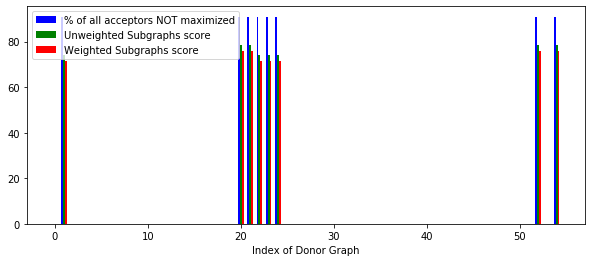

In [50]:
graphs_idx = [i for i in range(len(graph_list))]

fig = plt.figure(figsize = (10,4))
plt.bar([i - 0.2 for i in graphs_idx], [i*100/len(graph_list) for i in acc_maxxed],color = 'b' , width = 0.2, label = '% of all acceptors NOT maximized')
plt.bar([i for i in graphs_idx], [i*100 for i in unweighted_scores],color = 'g' , width = 0.2, label = 'Unweighted Subgraphs score')
plt.bar([i +0.2 for i in graphs_idx], [i*100 for i in weighted_scores],color = 'r',width = 0.2 , label = 'Weighted Subgraphs score')

plt.xlabel("Index of Donor Graph")
plt.legend()
plt.show()

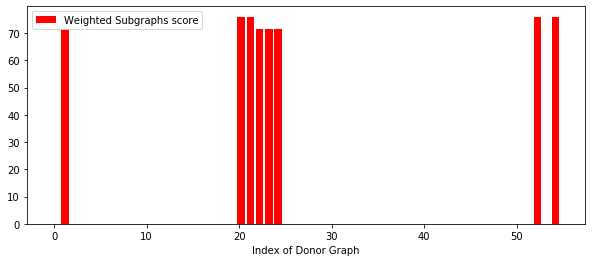

In [51]:
graphs_idx = [i for i in range(len(graph_list))]

fig = plt.figure(figsize = (10,4))
#plt.bar([i - 0.2 for i in graphs_idx], [i*100/len(graph_list) for i in acc_maxxed],color = 'b' , width = 0.2, label = '% of all acceptors maximized')
#plt.bar([i for i in graphs_idx], [i*100 for i in unweighted_scores],color = 'g' , width = 0.2, label = 'Unweighted Subgraphs score')
plt.bar([i +0.2 for i in graphs_idx], [i*100 for i in weighted_scores],color = 'r' , label = 'Weighted Subgraphs score')

plt.xlabel("Index of Donor Graph")
plt.legend()
plt.show()

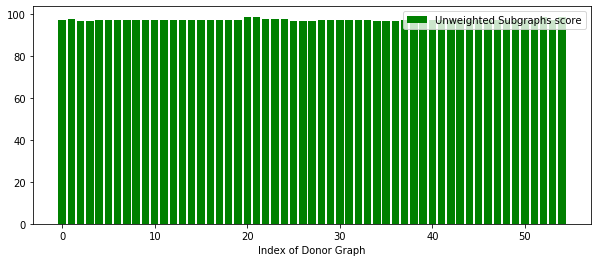

In [90]:
graphs_idx = [i for i in range(len(graph_list))]

fig = plt.figure(figsize = (10,4))
#plt.bar([i - 0.2 for i in graphs_idx], [i*100/len(graph_list) for i in acc_maxxed],color = 'b' , width = 0.2, label = '% of all acceptors maximized')
plt.bar([i for i in graphs_idx], [i*100 for i in unweighted_scores],color = 'g' , label = 'Unweighted Subgraphs score')
#plt.bar([i +0.2 for i in graphs_idx], [i*100 for i in weighted_scores],color = 'r' , label = 'Weighted Subgraphs score')

plt.xlabel("Index of Donor Graph")
plt.legend()
plt.show()

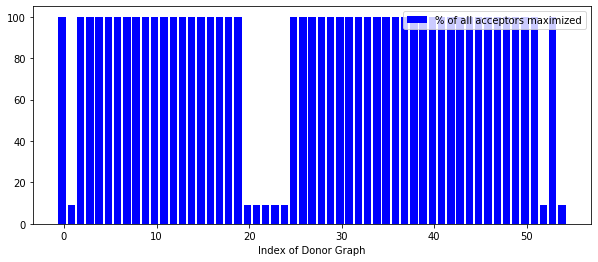

In [91]:
graphs_idx = [i for i in range(len(graph_list))]

fig = plt.figure(figsize = (10,4))
plt.bar([i - 0.2 for i in graphs_idx], [i*100/len(graph_list) for i in acc_maxxed],color = 'b' , label = '% of all acceptors maximized')
#plt.bar([i for i in graphs_idx], [i*100 for i in unweighted_scores],color = 'g' , width = 0.2, label = 'Unweighted Subgraphs score')
#plt.bar([i +0.2 for i in graphs_idx], [i*100 for i in weighted_scores],color = 'r' , label = 'Weighted Subgraphs score')

plt.xlabel("Index of Donor Graph")
plt.legend()
plt.show()

# looking at a special case

donor 


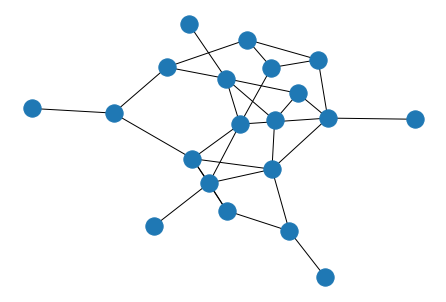

acceptor


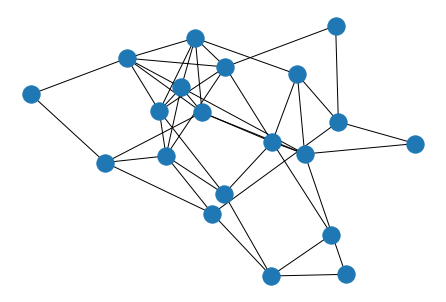

In [132]:
print('donor ')
nx.draw(g_list[0])
plt.show()
print('acceptor')
nx.draw(g_list[52])
plt.show()


In [95]:
g1 = g_list[0]
g2 = g_list[52]
g1_results = g_data[0]
g2_results = g_data[52]
similarity(g1, g2, g_all, tranf_mat_mod)

0.6583381088904167

In [97]:
float(actual_sim(g1, g2,g1_results, g2_results))

0.9955340440772634

In [99]:
def mod_similarity(G1, G2, subgraphs , tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
    ####debug statements
      print('###################')
      print(i)
      print(j)
      print(tranf_mat[i,j])
    ###########
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
  metric = metric/total_arrows
  return metric

In [100]:
mod_similarity(g1, g2, g_all, tranf_mat_mod)

###################
22
29
0.47837882329364073
###################
22
28
0.5098315490884275
###################
22
37
0.5355490889344898
###################
22
10
0.44377013907975454
###################
22
36
0.5570996495401292
###################
22
53
0.5472034309819409
###################
22
51
0.5898403352334118
###################
22
54
0.5106364505681986
###################
22
52
0.5722461716076946
###################
22
14
0.4924712472988803
###################
22
50
0.6035379724943055
###################
40
29
0.4876665138850629
###################
40
28
0.5132988483135095
###################
40
37
0.5322329409171213
###################
40
10
0.4592379230733342
###################
40
36
0.5527750240130372
###################
40
53
0.5305149855780541
###################
40
51
0.5753368740177076
###################
40
54
0.4977812195908671
###################
40
52
0.5557015930926776
###################
40
14
0.5009640109496892
###################
40
50
0.591038830363452
#########

0.6583381088904167

#### Let's pick 40 and 10

donor subgraph


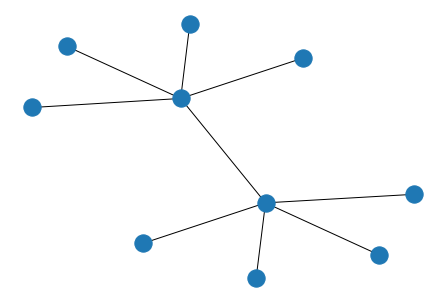

acceptor subgraph


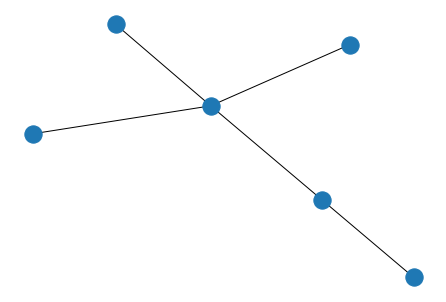

In [130]:
print('donor subgraph')
nx.draw(g_all[40])
plt.show()
print('acceptor subgraph')
nx.draw(g_all[10])
plt.show()



In [111]:
tranf_mat_mod[40,10]

0.4592379230733342

In [112]:
tranf_mat_mod[10,40]

0.9686744652560172

In [113]:
def actual_sim_g_sub(G1, sub_G2,g1_results, sub_g2_results):
  """
  Returns similarity between two graphs computed directly
  """
  #Now computing similarity
  sim = 0
  acc_max_energy = sub_g2_results[2]
  donor_gamma = g1_results[0]
  donor_beta = g1_results[1]

  loss = get_edge_contribution(graph = sub_G2, edge = (0,1), gamma = [donor_gamma], beta = [donor_beta])
  transf_energy = (1-loss)/2
  #print(transf_energy)
  sim = transf_energy/acc_max_energy
  return sim

In [114]:
i=40
sub_G2 = g_all[i]
sub_g2_results = subgraph_data[i]
actual_sim_g_sub(g1, sub_G2,g1_results, sub_g2_results)

0.9912298760790386

In [115]:
i=10
sub_G2 = g_all[i]
sub_g2_results = subgraph_data[i]
actual_sim_g_sub(g1, sub_G2,g1_results, sub_g2_results)

0.99212466677064

In [116]:
i=10 #acceptor
j=40 #donor
sub_G1 = g_all[j]
sub_g1_results = subgraph_data[j]
sub_G2 = g_all[i]
sub_g2_results = subgraph_data[i]
actual_sim_g_sub(sub_G1, sub_G2,sub_g1_results, sub_g2_results)

0.4592224044567964

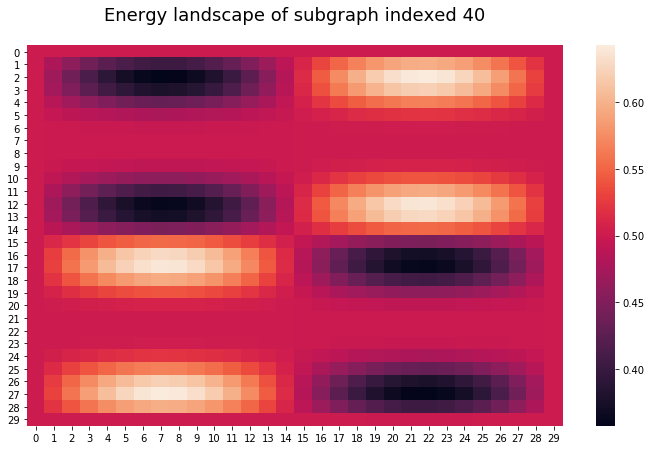

In [128]:
step = 30
gamma = np.linspace(0, 1, num = step)
beta = np.linspace(0, 0.5, num = step)
data = np.zeros((step, step))

for i in range(step):
  for j in range(step):
    data[i, j] = (1-get_edge_contribution(g_all[40], (0,1), [gamma[i]], [beta[j]]))/2
fig, ax = plt.subplots(figsize = (12, 7))
title = "Energy landscape of subgraph indexed 40"
plt.title(title, fontsize = 18)
ttl = ax.title
ttl.set_position([0.5, 1.05])
sns.heatmap(data, ax = ax)

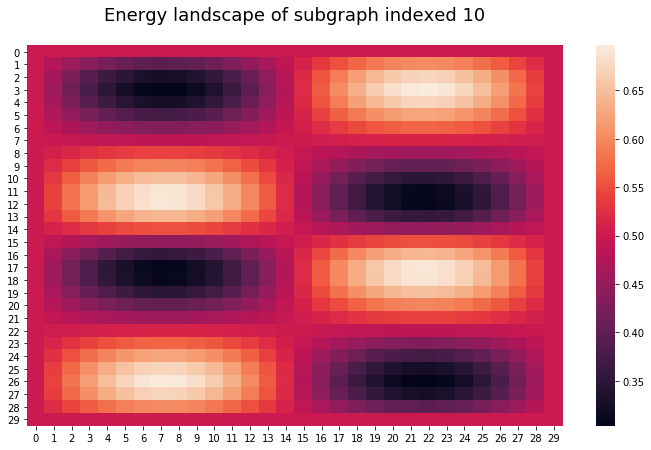

In [126]:
step = 30
gamma = np.linspace(0, 1, num = step)
beta = np.linspace(0, 0.5, num = step)
data = np.zeros((step, step))

for i in range(step):
  for j in range(step):
    data[i, j] = (1-get_edge_contribution(g_all[10], (0,1), [gamma[i]], [beta[j]]))/2
fig, ax = plt.subplots(figsize = (12, 7))
title = "Energy landscape of subgraph indexed 10"
plt.title(title, fontsize = 18)
ttl = ax.title
ttl.set_position([0.5, 1.05])
sns.heatmap(data, ax = ax)

In [122]:
subgraph_data[40]

[0.4261966347694397, 0.375, 0.6431084424257278]

In [124]:
subgraph_data[10]

[0.60235196352005, 0.8749914169311523, 0.6968001574277878]

In [123]:
g_data[0]

[0.9126172661781311, 1.117039442062378, 20.284748996816113, nan]

In [129]:
g_data[52]

[0.4245850443840027,
 1.1113555431365967,
 27.370563719310656,
 21.394691263739865]